First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [ ]:
!conda create -n BI2025 python=3.11 -y
!conda activate BI2025
!pip install -r requirements.txt

In [1]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [2]:
#executed_by = 'stud-id_12019873'  # Replace the digits after "id_" with your own student ID
executed_by = 'stud-id_12120509'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [3]:
# group id for this project
group_id = '43'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12019873'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12120509'  # Replace the digits after "id_" with student B's student ID

In [4]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [5]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [6]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [7]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3] + "Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [8]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
    f':{student_a} rdf:type foaf:Person .',
    f':{student_a} rdf:type prov:Agent .',
    f':{student_a} foaf:givenName "Johanna" .',
    f':{student_a} foaf:familyName "Six" .',
    f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
    f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
    f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
    f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "12019873"^^xsd:string .',
]

reigstration_triples_b = [
    f':{student_b} rdf:type foaf:Person .',
    f':{student_b} rdf:type prov:Agent .',
    f':{student_b} foaf:givenName "Bernhard" .',
    f':{student_b} foaf:familyName "Siegl" .',
    f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
    f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
    f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
    f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "76543210"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]

engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

In [9]:
airline_data_path = os.path.join("data", "airline")

## Business Understanding 

In [10]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
    f':business_understanding_phase rdf:type prov:Activity .',
    f':business_understanding_phase rdfs:label "Business Understanding Phase" .',  ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [11]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
The data source consists of 21 attributes and about 3000 rows. It contains data from December 2019 and 2020, that consists of the number of delayed, cancelled or diverted flights and the cause of delays. The data can be used by airlines to identify what causes the most flight delays / cancellations.
"""

business_objectives_comment = """
The airline wants to improve punctuality and therefore reduce the number of delayed, cancelled flights.
"""

business_success_criteria_comment = """
The success criteria are: improvement of on time performance. Delayed flights are reduced by at least 5 percent in the next year.
Top 10 airports are identified with the most delays, cancelled flights and monitored.
"""

data_mining_goals_comment = """
We need to identify the main drivers of delays and cancellations by analyzing delay causes, airport, airline and temporal factors;
Quantify the distribution of delay categories (weather, carrier, security, NAS, ..);
Identify airports and airlines with significant higher delays/cancellations;
Build models to estimate the likelihood of delays for a given airport, airline and time.
"""

data_mining_success_criteria_comment = """
Clustering results to show interpretable groupings of airports based on their delay and cancellation behaviour,
Achieve a accuraccy of at least 70% with our classification model
"""

ai_risk_aspects_comment = """
The system should be low-risk, as it supports operational analysis and decision-making rather than automated enforcement or individual-level decisions
"""

bu_ass_uuid_executor = "bb6a40f9-9d92-4f9f-bbd2-b65ef6a82da2"  # Generate once
business_understanding_executor = [
    f':business_understanding rdf:type prov:Activity .',
    f':business_understanding sc:isPartOf :business_understanding_phase .',
    # Connect Activity to Parent Business Understanding Phase Activity
    f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
    f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{bu_ass_uuid_executor} rdf:type prov:Association .',
    f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)

business_understanding_data_executor = [
    # 1a
    f':bu_data_source_and_scenario rdf:type prov:Entity .',
    f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
    f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
    f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
    # 1b
    f':bu_business_objectives rdf:type prov:Entity .',
    f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
    f':bu_business_objectives rdfs:label "1b Business Objectives" .',
    f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
    # 1c
    f':bu_business_success_criteria rdf:type prov:Entity .',
    f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
    f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
    f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
    # 1d
    f':bu_data_mining_goals rdf:type prov:Entity .',
    f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
    f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
    f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
    # 1e
    f':bu_data_mining_success_criteria rdf:type prov:Entity .',
    f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
    f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
    f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
    # 1f
    f':bu_ai_risk_aspects rdf:type prov:Entity .',
    f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
    f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
    f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

The following pseudo-code & pseudo-documentation may be used as a hint.

In [12]:
## Each Activity that follows is part of the Data Understanding Phase

business_understanding_phase_executor = [
    f':data_understanding_phase rdf:type prov:Activity .',
    f':data_understanding_phase rdfs:label "Data Understanding Phase" .',
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [13]:
airline_data_path = os.path.join("data", "airline")
load_airline_data_code_writer = student_a


def load_airline_data() -> pd.DataFrame:
    ### Load your data
    input_file = os.path.join(airline_data_path, 'airline_delay.csv')
    raw_data = pd.read_csv(input_file, sep=',', header=0)

    raw_data.sort_values(['year', 'month'], inplace=True)
    raw_data.set_index(['year', 'month', 'carrier', 'airport'], inplace=True)

    return raw_data


start_time_ld = now()
data = load_airline_data()
end_time_ld = now()

display(data.head())

#############################################
# Documentation
#############################################

# Now document the raw data and the loaded data using appropriate ontologies.

# Always add these triples for every activity to define the executor!
ld_ass_uuid_executor = "b8bac193-c4e6-4e31-9134-b23e001e279c"  # Generate once
load_airline_data_executor = [
    f':load_airline_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(load_airline_data_executor, prefixes=prefixes)

ld_ass_uuid_writer = "c600e15c-87a9-4e2a-be85-b6c2a3014210"  # Generate once
ld_report = """
Load all airline data and create a hierarchical index (year, month).
"""
load_airline_data_activity = [
    ':load_airline_data rdf:type prov:Activity .',
    ':load_airline_data sc:isPartOf :data_understanding_phase .',
    ':load_airline_data rdfs:comment \'Data Understanding\' .',
    f':load_airline_data rdfs:comment """{ld_report}""" .',
    f':load_airline_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_airline_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    f':load_airline_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_airline_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # INPUT of activity
    ':load_airline_data prov:used :raw_data .',
    ':load_airline_data prov:used :raw_data_path .',
    ':raw_data rdf:type prov:Entity .',
    ':raw_data_path rdf:type prov:Entity .',
    ':raw_data prov:wasDerivedFrom :raw_data_path .',
    # OUTPUT of activity
    ':data rdf:type prov:Entity .',
    ':data prov:wasGeneratedBy :load_airline_data .',
    ':data prov:wasDerivedFrom :raw_data .',
]
engine.insert(load_airline_data_activity, prefixes=prefixes)

# Further descibe the raw data using Croissant
raw_data_triples = [
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data sc:name \'Airline Delay Dataset (Dec 2019–2020)\' .',
    ':raw_data sc:description \'Summary airline delay counts per carrier per US city for December 2019 and 2020.\' .',

    # Continue with futher information about the dataset...
    ':airline_delay_csv rdf:type cr:FileObject .',
    ':airline_delay_csv sc:name \'airline_delay.csv\' .',
    ':airline_delay_csv sc:encodingFormat \'text/csv\' .',
    ':raw_data sc:distribution :airline_delay .',
    # Continue with further information about the distribution...
    ':raw_recordset rdf:type cr:RecordSet .',
    ':raw_recordset sc:name \'Table of airline data for december for 2019 and 2020\' .',
    ':raw_recordset cr:source :airline_delay_csv .',
    ':raw_data cr:recordSet :raw_recordset .',

    ':raw_recordset cr:field :field_year .',
    ':field_year rdf:type cr:Field .',
    ':field_year sc:name \'year\' .',
    ':field_year sc:description \'Year in which flight data was collected.\' .',
    ':field_year cr:dataType xsd:gYear .',

    ':raw_recordset cr:field :field_month .',
    ':field_month rdf:type cr:Field .',
    ':field_month sc:name \'month\' .',
    ':field_month sc:description \'Month (1–12) of data collection.\' .',
    ':field_month cr:dataType xsd:integer .',
    ':field_month qudt:unit qudt: qudt:DateTimeStringEncodingType  .',

    ':raw_recordset cr:field :field_carrier .',
    ':field_carrier rdf:type cr:Field .',
    ':field_carrier sc:name \'carrier\' .',
    ':field_carrier sc:description \'Two-letter airline carrier code.\' .',
    ':field_carrier cr:dataType xsd:string .',

    ':raw_recordset cr:field :field_carrier_name .',
    ':field_carrier_name rdf:type cr:Field .',
    ':field_carrier_name sc:name \'carrier_name\' .',
    ':field_carrier_name sc:description \'Full airline carrier name.\' .',
    ':field_carrier_name cr:dataType xsd:string .',

    ':raw_recordset cr:field :field_airport .',
    ':field_airport rdf:type cr:Field .',
    ':field_airport sc:name \'airport\' .',
    ':field_airport sc:description \'Three-letter airport code for arrival airport.\' .',
    ':field_airport cr:dataType xsd:string .',

    ':raw_recordset cr:field :field_airport_name .',
    ':field_airport_name rdf:type cr:Field .',
    ':field_airport_name sc:name \'airport_name\' .',
    ':field_airport_name sc:description \'Full name of the airport.\' .',
    ':field_airport_name cr:dataType xsd:string .',

    # Count fields
    ':raw_recordset cr:field :field_arr_flights .',
    ':field_arr_flights rdf:type cr:Field .',
    ':field_arr_flights sc:name \'arr_flights\' .',
    ':field_arr_flights sc:description \'Number of flights arriving at airport.\' .',
    ':field_arr_flights cr:dataType xsd:integer .',
    ':field_arr_flights qudt:unit qudt:CountingUnit .',

    ':raw_recordset cr:field :field_arr_del15 .',
    ':field_arr_del15 rdf:type cr:Field .',
    ':field_arr_del15 sc:name \'arr_del15\' .',
    ':field_arr_del15 sc:description \'Flights arriving more than 15 minutes late.\' .',
    ':field_arr_del15 cr:dataType xsd:integer .',
    ':field_arr_del15 qudt:unit qudt:CountingUnit .',

    ':raw_recordset cr:field :field_carrier_ct .',
    ':field_carrier_ct rdf:type cr:Field .',
    ':field_carrier_ct sc:name \'carrier_ct\' .',
    ':field_carrier_ct sc:description \'Flights delayed due to air carrier (e.g. crew).\' .',
    ':field_carrier_ct cr:dataType xsd:integer .',
    ':field_carrier_ct qudt:unit qudt:CountingUnit .',

    ':raw_recordset cr:field :field_weather_ct .',
    ':field_weather_ct rdf:type cr:Field .',
    ':field_weather_ct sc:name \'weather_ct\' .',
    ':field_weather_ct sc:description \'Flights delayed due to weather.\' .',
    ':field_weather_ct cr:dataType xsd:integer .',
    ':field_weather_ct qudt:unit qudt:CountingUnit .',

    ':raw_recordset cr:field :field_nas_ct .',
    ':field_nas_ct rdf:type cr:Field .',
    ':field_nas_ct sc:name \'nas_ct\' .',
    ':field_nas_ct sc:description \'Flights delayed due to National Aviation System.\' .',
    ':field_nas_ct cr:dataType xsd:integer .',
    ':field_nas_ct qudt:unit qudt:CountingUnit .',

    ':raw_recordset cr:field :field_security_ct .',
    ':field_security_ct rdf:type cr:Field .',
    ':field_security_ct sc:name \'security_ct\' .',
    ':field_security_ct sc:description \'Flights canceled due to security issues.\' .',
    ':field_security_ct cr:dataType xsd:integer .',
    ':field_security_ct qudt:unit qudt:CountingUnit .',

    ':raw_recordset cr:field :field_late_aircraft_ct .',
    ':field_late_aircraft_ct rdf:type cr:Field .',
    ':field_late_aircraft_ct sc:name \'late_aircraft_ct\' .',
    ':field_late_aircraft_ct sc:description \'Flights delayed due to a previous late aircraft.\' .',
    ':field_late_aircraft_ct cr:dataType xsd:integer .',
    ':field_late_aircraft_ct qudt:unit qudt:CountingUnit .',

    ':raw_recordset cr:field :field_arr_cancelled .',
    ':field_arr_cancelled rdf:type cr:Field .',
    ':field_arr_cancelled sc:name \'arr_cancelled\' .',
    ':field_arr_cancelled sc:description \'Number of cancelled flights.\' .',
    ':field_arr_cancelled cr:dataType xsd:integer .',
    ':field_arr_cancelled qudt:unit qudt:CountingUnit .',

    ':raw_recordset cr:field :field_arr_diverted .',
    ':field_arr_diverted rdf:type cr:Field .',
    ':field_arr_diverted sc:name \'arr_diverted\' .',
    ':field_arr_diverted sc:description \'Number of diverted flights.\' .',
    ':field_arr_diverted cr:dataType xsd:integer .',
    ':field_arr_diverted qudt:unit qudt:CountingUnit .',

    # Delay time (minutes)
    ':raw_recordset cr:field :field_arr_delay .',
    ':field_arr_delay rdf:type cr:Field .',
    ':field_arr_delay sc:name \'arr_delay\' .',
    ':field_arr_delay sc:description \'Total delay time in minutes.\' .',
    ':field_arr_delay cr:dataType xsd:double .',
    ':field_arr_delay qudt:unit qudt:Minute .',

    ':raw_recordset cr:field :field_carrier_delay .',
    ':field_carrier_delay rdf:type cr:Field .',
    ':field_carrier_delay sc:name \'carrier_delay\' .',
    ':field_carrier_delay sc:description \'Delay minutes due to air carrier issues.\' .',
    ':field_carrier_delay cr:dataType xsd:double .',
    ':field_carrier_delay qudt:unit qudt:Minute .',

    ':raw_recordset cr:field :field_weather_delay .',
    ':field_weather_delay rdf:type cr:Field .',
    ':field_weather_delay sc:name \'weather_delay\' .',
    ':field_weather_delay sc:description \'Delay minutes due to weather.\' .',
    ':field_weather_delay cr:dataType xsd:double .',
    ':field_weather_delay qudt:unit qudt:Minute .',

    ':raw_recordset cr:field :field_nas_delay .',
    ':field_nas_delay rdf:type cr:Field .',
    ':field_nas_delay sc:name \'nas_delay\' .',
    ':field_nas_delay sc:description \'Delay minutes due to National Aviation System.\' .',
    ':field_nas_delay cr:dataType xsd:double .',
    ':field_nas_delay qudt:unit qudt:Minute .',

    ':raw_recordset cr:field :field_security_delay .',
    ':field_security_delay rdf:type cr:Field .',
    ':field_security_delay sc:name \'security_delay\' .',
    ':field_security_delay sc:description \'Delay minutes due to security issues.\' .',
    ':field_security_delay cr:dataType xsd:double .',
    ':field_security_delay qudt:unit qudt:Minute .',

    ':raw_recordset cr:field :field_late_aircraft_delay .',
    ':field_late_aircraft_delay rdf:type cr:Field .',
    ':field_late_aircraft_delay sc:name \'late_aircraft_delay\' .',
    ':field_late_aircraft_delay sc:description \'Delay minutes due to previous late aircraft.\' .',
    ':field_late_aircraft_delay cr:dataType xsd:double .',
    ':field_late_aircraft_delay qudt:unit qudt:Minute .',
]
engine.insert(raw_data_triples, prefixes=prefixes)

# Also the output of the load activity is a dataset that can be described with Croissant
data_triples = [
    ':data rdf:type sc:Dataset .',
    # ...
    ':recordset rdf:type cr:RecordSet .',
    # ...
    ':data cr:recordSet :recordset .',
    # ...
    # Fields can also be reused
    ':recordset cr:field :field_date .',
    ':recordset cr:field :field_number .',
    # The loaded data has additional fields
    ':recordset cr:field :field_day_of_week .',
    ':field_day_of_week rdf:type cr:Field .',
    ':field_day_of_week sc:name \'day_of_week\' .',
    ':field_day_of_week sc:description \'Day of week description\' .',
    ':field_day_of_week cr:dataType xsd:string .',
    # This is not actually a field in the dataframe but below demonstrates how units may be used
    ':recordset cr:field :field_temp .',
    ':field_temp rdf:type cr:Field .',
    ':field_temp sc:name \'temperature\' .',
    ':field_temp sc:description \'Description Temperature\' .',
    ':field_temp cr:dataType xsd:double .',
]
engine.insert(data_triples, prefixes=prefixes)

# Also add the units to the fields
units_triples = [
    ':field_number qudt:unit qudt:CountingUnit .',
    ':field_temp qudt:unit siu:degree_Celsius .',

    ':field_year qudt:unit qudt: qudt:DateTimeStringEncodingType  .',

]
engine.insert(units_triples, prefixes=prefixes)

carrier_name  \
year month carrier airport                            
2019 12    EV      BDL      ExpressJet Airlines LLC   
                   BGR      ExpressJet Airlines LLC   
                   BHM      ExpressJet Airlines LLC   
                   BNA      ExpressJet Airlines LLC   
                   BRO      ExpressJet Airlines LLC   

                                                                 airport_name  \
year month carrier airport                                                      
2019 12    EV      BDL                    Hartford, CT: Bradley International   
                   BGR                       Bangor, ME: Bangor International   
                   BHM      Birmingham, AL: Birmingham-Shuttlesworth Inter...   
                   BNA                 Nashville, TN: Nashville International   
                   BRO      Brownsville, TX: Brownsville South Padre Islan...   

                            arr_flights  arr_del15  carrier_ct  weather_ct  \
year month carrier airport                                                   
2019 12    EV      BDL             14.0        4.0        2.00        0.00   
                   BGR             34.0       16.0        4.12        0.00   
                   BHM             65.0       13.0        4.52        0.04   
                   BNA            120.0       41.0       11.01        0.74   
                   BRO             96.0       17.0        8.01        0.00   

                            nas_ct  security_ct  late_aircraft_ct  \
year month carrier airport                                          
2019 12    EV      BDL        0.00          0.0              2.00   
                   BGR        3.90          0.0              7.98   
                   BHM        5.96          0.0              2.48   
                   BNA       13.99          0.0             15.25   
                   BRO        4.66          0.0              4.33   

                            arr_cancelled  arr_diverted  arr_delay  \
year month carrier airport                                           
2019 12    EV      BDL                0.0           0.0      114.0   
                   BGR                2.0           0.0     1450.0   
                   BHM                0.0           0.0      572.0   
                   BNA                6.0           0.0     2638.0   
                   BRO                1.0           0.0     1037.0   

                            carrier_delay  weather_delay  nas_delay  \
year month carrier airport                                            
2019 12    EV      BDL               61.0            0.0        0.0   
                   BGR              682.0            0.0      231.0   
                   BHM              233.0            2.0      206.0   
                   BNA              670.0          164.0      685.0   
                   BRO              578.0            0.0      139.0   

                            security_delay  late_aircraft_delay  
year month carrier airport                                       
2019 12    EV      BDL                 0.0                 53.0  
                   BGR                 0.0                537.0  
                   BHM                 0.0                131.0  
                   BNA                 0.0               1119.0  
                   BRO                 0.0                320.0

QueryBadFormed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'MALFORMED QUERY: number of values in bindingset does not match variables in BINDINGS clause'

In [14]:
numeric_stats = data.describe().T
print(numeric_stats)

                      count         mean           std  min     25%     50%  \
arr_flights          3343.0   298.271014    852.436335  1.0   35.00   83.00   
arr_del15            3343.0    50.995214    146.484456  0.0    5.00   12.00   
carrier_ct           3343.0    16.065337     41.759516  0.0    1.49    4.75   
weather_ct           3343.0     1.443144      4.821657  0.0    0.00    0.06   
nas_ct               3343.0    16.183383     56.423008  0.0    0.82    2.98   
security_ct          3343.0     0.137320      0.646479  0.0    0.00    0.00   
late_aircraft_ct     3343.0    17.166069     55.447043  0.0    0.90    3.28   
arr_cancelled        3343.0     2.884535     10.126658  0.0    0.00    0.00   
arr_diverted         3343.0     0.575830      2.097884  0.0    0.00    0.00   
arr_delay            3343.0  3333.868083  10284.926623  0.0  230.00  746.00   
carrier_delay        3343.0  1144.763087   3371.103512  0.0   68.50  272.00   
weather_delay        3343.0   177.591385    734.3435

In [15]:
#check missing values
missing = {
    col: data.index[data[col].isna()].tolist()
    for col in data.columns
    if data[col].isna().any()
}
for col, count in missing.items():
    print(f"{col}: {count}")


arr_flights: [(2019, 12, 'OO', 'MLB'), (2020, 12, 'DL', 'BIL'), (2020, 12, 'DL', 'CHA'), (2020, 12, 'DL', 'FAI'), (2020, 12, 'OO', 'BDL'), (2020, 12, 'OO', 'PWM'), (2020, 12, 'UA', 'PNS'), (2020, 12, 'UA', 'STL')]
arr_del15: [(2019, 12, 'OO', 'MLB'), (2020, 12, 'DL', 'BIL'), (2020, 12, 'DL', 'CHA'), (2020, 12, 'DL', 'FAI'), (2020, 12, 'OO', 'BDL'), (2020, 12, 'OO', 'PWM'), (2020, 12, 'UA', 'PNS'), (2020, 12, 'UA', 'STL')]
carrier_ct: [(2019, 12, 'OO', 'MLB'), (2020, 12, 'DL', 'BIL'), (2020, 12, 'DL', 'CHA'), (2020, 12, 'DL', 'FAI'), (2020, 12, 'OO', 'BDL'), (2020, 12, 'OO', 'PWM'), (2020, 12, 'UA', 'PNS'), (2020, 12, 'UA', 'STL')]
weather_ct: [(2019, 12, 'OO', 'MLB'), (2020, 12, 'DL', 'BIL'), (2020, 12, 'DL', 'CHA'), (2020, 12, 'DL', 'FAI'), (2020, 12, 'OO', 'BDL'), (2020, 12, 'OO', 'PWM'), (2020, 12, 'UA', 'PNS'), (2020, 12, 'UA', 'STL')]
nas_ct: [(2019, 12, 'OO', 'MLB'), (2020, 12, 'DL', 'BIL'), (2020, 12, 'DL', 'CHA'), (2020, 12, 'DL', 'FAI'), (2020, 12, 'OO', 'BDL'), (2020, 12, 'OO

In [16]:
def check_skewness(df: pd.DataFrame, column: str):
    s = df[column].dropna()
    sk = s.skew()
    print(f"Skewness of '{column}': {sk:.3f}")
    return sk

numeric_cols = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay' ]
for col in numeric_cols:
    check_skewness(data, col)


Skewness of 'arr_flights': 8.691
Skewness of 'arr_del15': 6.861
Skewness of 'carrier_ct': 7.167
Skewness of 'weather_ct': 9.358
Skewness of 'nas_ct': 8.779
Skewness of 'security_ct': 10.734
Skewness of 'late_aircraft_ct': 7.374
Skewness of 'arr_cancelled': 9.230
Skewness of 'arr_diverted': 10.504
Skewness of 'arr_delay': 7.452
Skewness of 'carrier_delay': 7.994
Skewness of 'weather_delay': 10.293
Skewness of 'nas_delay': 12.494
Skewness of 'security_delay': 10.008
Skewness of 'late_aircraft_delay': 7.842


In [17]:
#check correlation
numeric_cols = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay' ]
flight_corr = data[numeric_cols].corr()
print(flight_corr)

                     arr_flights  arr_del15  carrier_ct  weather_ct    nas_ct  \
arr_flights             1.000000   0.928553    0.913941    0.728294  0.821692   
arr_del15               0.928553   1.000000    0.925558    0.697453  0.912643   
carrier_ct              0.913941   0.925558    1.000000    0.687277  0.741848   
weather_ct              0.728294   0.697453    0.687277    1.000000  0.598149   
nas_ct                  0.821692   0.912643    0.741848    0.598149  1.000000   
security_ct             0.525694   0.529340    0.550511    0.329421  0.423072   
late_aircraft_ct        0.859181   0.949273    0.870981    0.625493  0.777828   
arr_cancelled           0.602233   0.671842    0.585325    0.503454  0.619514   
arr_diverted            0.502627   0.553319    0.466475    0.463821  0.540636   
arr_delay               0.856262   0.960250    0.851834    0.731967  0.901357   
carrier_delay           0.887762   0.908416    0.919436    0.769016  0.775503   
weather_delay           0.58

In [18]:
#check kurtosis
kurtosis = data.kurtosis(numeric_only=True)

print("\nKurtosis:\n", kurtosis)


Kurtosis:
 arr_flights            123.744088
arr_del15               61.438774
carrier_ct              73.625446
weather_ct             115.695268
nas_ct                 104.171473
security_ct            191.295280
late_aircraft_ct        68.782659
arr_cancelled          125.291689
arr_diverted           154.613759
arr_delay               72.225550
carrier_delay           87.983583
weather_delay          136.121660
nas_delay              223.086411
security_delay         137.612808
late_aircraft_delay     81.848748
dtype: float64


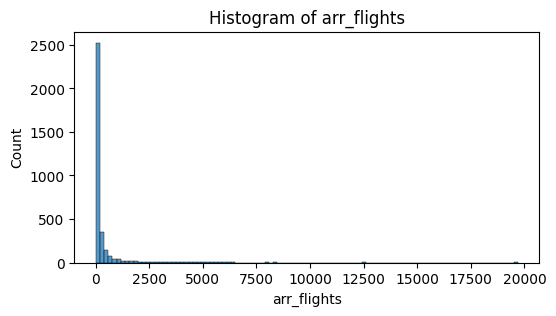

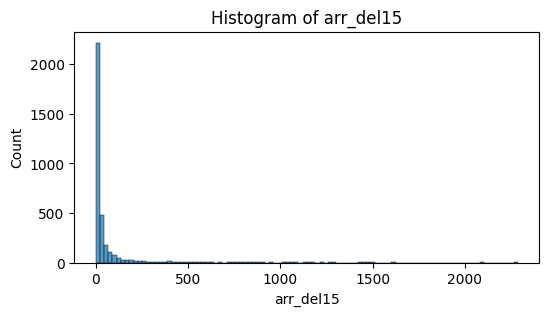

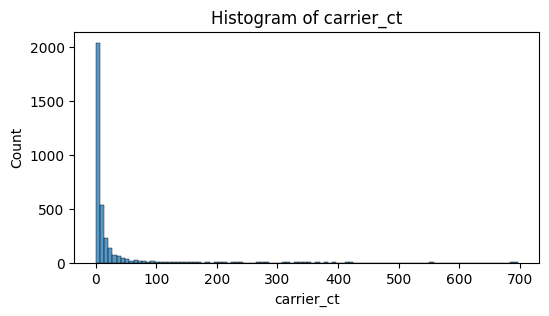

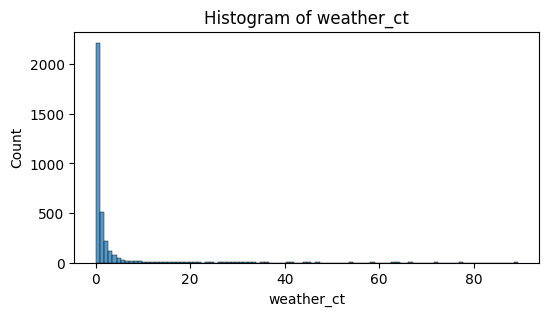

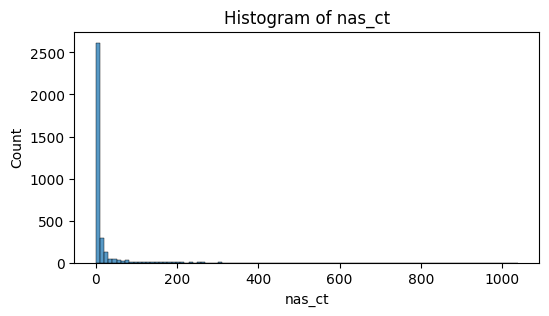

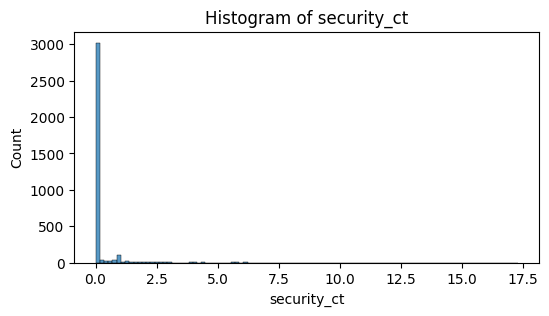

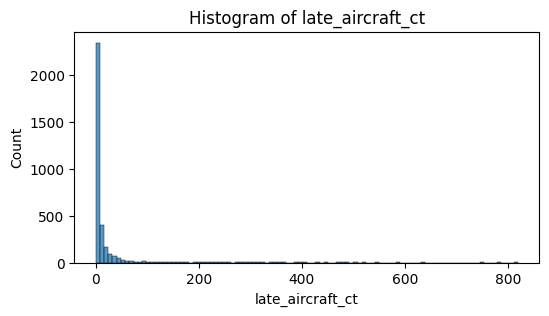

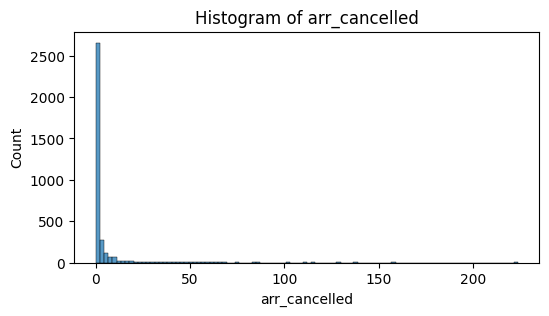

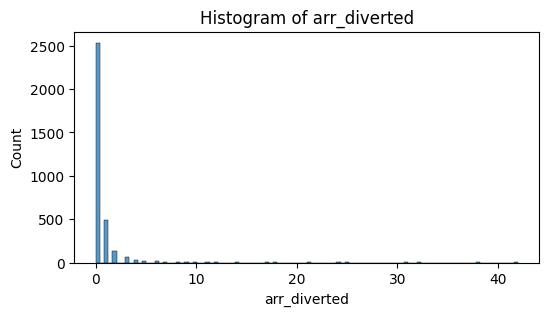

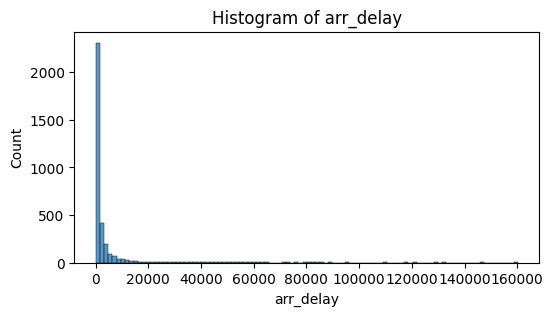

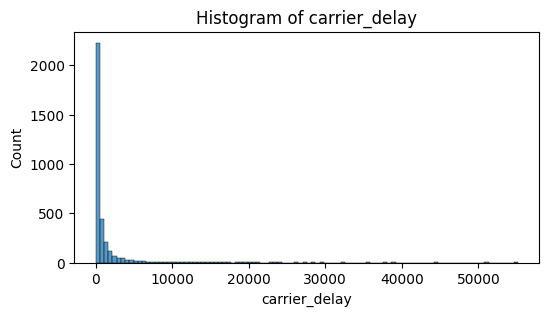

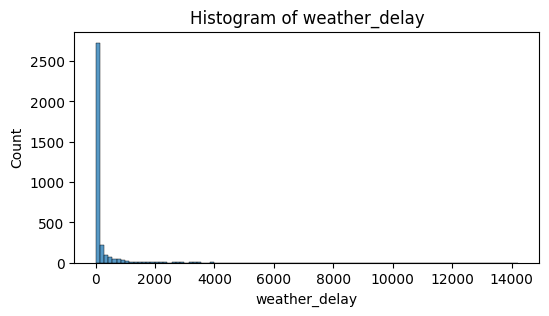

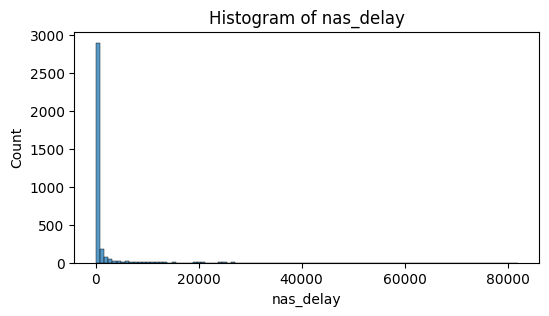

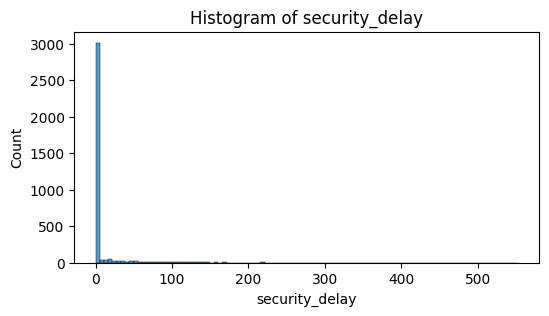

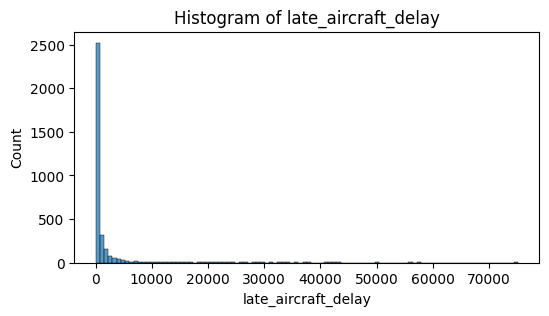

In [19]:
#visualize histogram
import seaborn

numeric_cols = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay' ]

for col in numeric_cols:
    plt.figure(figsize=(6,3))
    seaborn.histplot(data[col], bins=100, kde=False)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

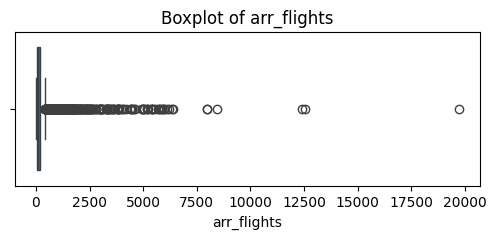

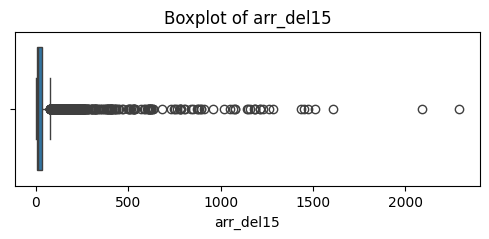

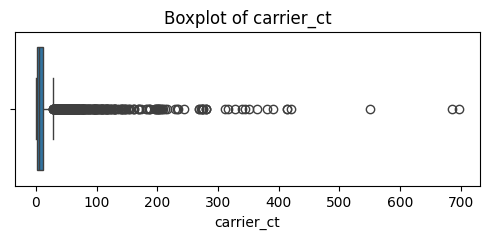

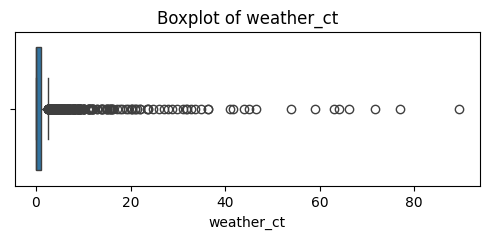

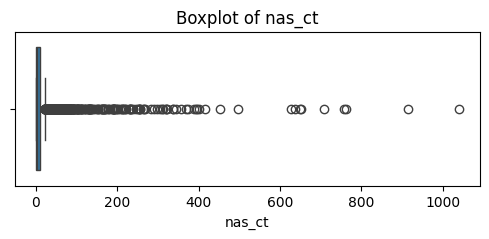

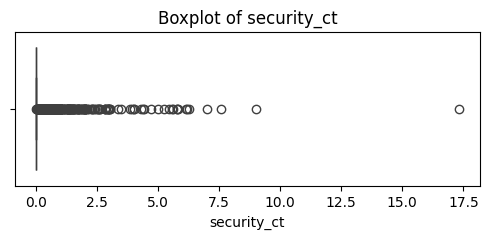

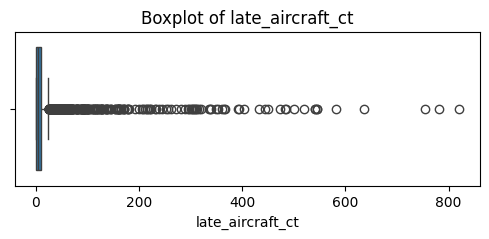

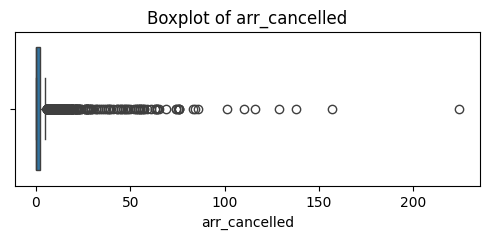

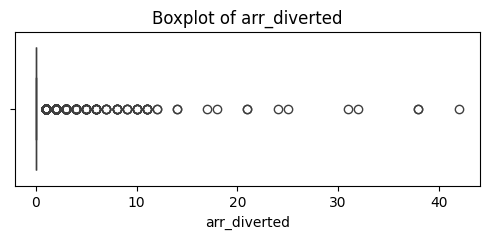

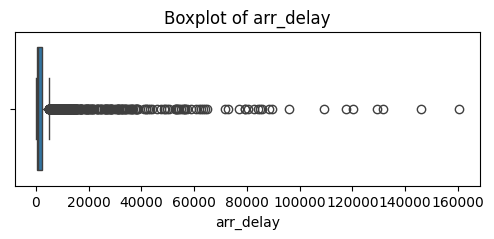

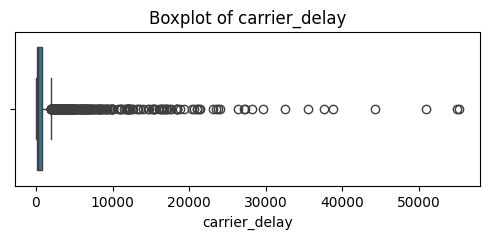

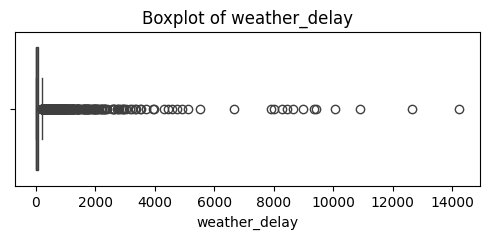

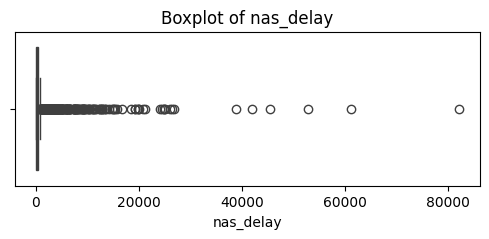

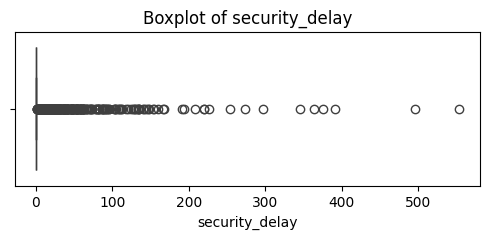

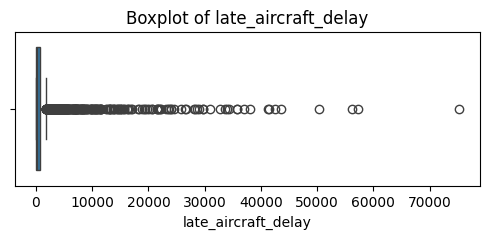

In [20]:
#visualize outliers
numeric_cols = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay' ]

for col in numeric_cols:
    plt.figure(figsize=(6,2))
    seaborn.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [21]:
check_outliers_code_writer = student_a


def check_outliers(data: pd.DataFrame, threshold=3.0, columns='arr_flights') -> dict:
    results = {}

    ### DIRTY HACK
    ### REPLACE WITH YOUR ACTUAL OUTLIER CHECKING

    tmp = data.copy()
    tmp = tmp.reset_index(drop=True)

    for col in columns:
        values = tmp[col].astype(float)

        mean = values.mean()
        std = values.std()

        if std == 0 or np.isnan(std):
            results[col] = []
            continue

        z_scores = (values - mean) / std

        mask = np.abs(z_scores) > threshold
        outliers = values[mask].index

        outlier_info = [
            {
                'index': int(idx),
                'z_score': float(z_scores.loc[idx])
            }
            for idx in outliers
        ]

        results[col] = outlier_info

    return results


start_time_co = now()
outlier_columns = list(data.columns[2::])
outliers_report = check_outliers(data, outlier_columns)
print(outliers_report)
end_time_co = now()

start_time_ho = now()
print(dataset_stats)
stats_json = dataset_stats.to_json(orient="index")
end_time_ho = now()

#############################################
# Documentation
#############################################
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => in this case a report
# 2. activity inspects the outcome and derives decisions => in this case to remove the outliers that were found
# 3. activity follows up on the decision by changing the data => will be done in the data preparation phase

# 1. Activty: Checking for outliers and creating the report
co_ass_uuid_executor = "15085e9d-15f1-4727-9b6e-776dd07fcd08"
check_outliers_executor = [
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_outliers_executor, prefixes=prefixes)

co_ass_uuid_writer = "cd4970df-9f40-4bb1-8fad-e4dc4fcdd284"
co_comment = """
Identifying outliers with a dirty hack that uses the z-score of each row within in column and reports all values
with a z-score higher than 2.2 as an outlier, which is not a reasonable threshold but used here to avoid not
finding any outliers for demonstration purposes.
"""
check_outliers_activity = [
    ':check_outliers rdf:type prov:Activity .',
    ':check_outliers sc:isPartOf :data_understanding_phase .',
    ':check_outliers rdfs:comment \'Data Understanding\' .',
    f':check_outliers rdfs:comment """{co_comment}""" .',
    f':check_outliers prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{check_outliers_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':dataset_description prov:used :data .',
    ':description_report rdf:type prov:Entity .',
    f':description_report rdfs:comment """{stats_json}""" .',
    ':description_report prov:wasGeneratedBy :dataset_description .',
    # ...
]
engine.insert(check_outliers_activity, prefixes=prefixes)

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = "6eaa2c0a-e592-4d85-b37f-d695844910cf"
ior_comment = """
After inspecting the report the decision has been made to remove all outliers that were identfied for demonstration purpose3
"""
inspect_outlier_report_executor = student_a
inspect_outlier_report_activity = [
    ':inspect_outlier_report rdf:type prov:Activity .',
    ':inspect_outlier_report rdfs:comment \'Data Understanding\' .',
    f':inspect_outlier_report rdfs:comment """{co_comment}""" .',
    f':inspect_outlier_report prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_outlier_report_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_outlier_report prov:used :outlier_report .',
    ':outlier_decision rdf:type prov:Entity .',
    f':outlier_decision rdfs:comment """Removing all outliers for demonstration purposes.""" .',
    ':outlier_decision prov:wasGeneratedBy :inspect_outlier_report .',
    # ...
]
engine.insert(inspect_dataset_description_activity, prefixes=prefixes)

KeyError: 'a'

In [22]:
skewness_check_code_writer = student_a

def check_skewness(df: pd.DataFrame, columns: list):
    skewness_dict = {}

    for column in columns:
        s = df[column].dropna()
        sk = s.skew()
        skewness_dict[column] = sk
    return skewness_dict

start_time_ho = now()
skewness_report = check_skewness(data, numeric_cols)
end_time_co = now()

start_time_co = now()
for col, count in skewness_report.items():
    print(f"{col}: {count}")
end_time_ho = now()

# 1. Activty: Checking for skewness and creating the report
co_ass_uuid_executor = "1790023e-315b-48f7-b39c-ba55c0341253"
skewness_check_executor = [
    f':skewness_check prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(skewness_check_executor, prefixes=prefixes)

co_ass_uuid_writer = "3a1bc808-4f3c-42a5-bcef-906363cba4ca"
co_comment = """
The dataset is checked for skewness in each numerical column. High absolute skewness
values may indicate that the data is not normally distributed and
may need transformation during the data preparation phase.
"""
skewness_check_activity = [
    ':skewness_check rdf:type prov:Activity .',
    ':skewness_check sc:isPartOf :data_understanding_phase .',
    ':skewness_check rdfs:comment \'Data Understanding\' .',
    f':skewness_check rdfs:comment """{co_comment}""" .',
    f':skewness_check prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':skewness_check prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':skewness_check prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{skewness_check_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':skewness_check prov:used :data .',
    ':skewness_report rdf:type prov:Entity .',
    f':skewness_report rdfs:comment """{json.dumps(skewness_report, indent=2)}""" .',
    ':skewness_report prov:wasGeneratedBy :skewness_check .',
]
engine.insert(skewness_check_activity, prefixes=prefixes)

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = "a6d6c34f-425d-4f76-871e-c234e51caeaa"
ior_comment = """
The report shows strong right skewness across all numeric columns. This indicates that most observations have low values while a small number of observations have very large values. The skewness is an indicator of the presence of outliers and the attributes not being normally distributed. Therefore needing transformation in the data preparation stage. NAS Delay shows the highest asymmetry.
"""
inspect_skewness_check_executor = student_a
inspect_skewness_check_activity = [
    ':inspect_skewness_check rdf:type prov:Activity .',
    ':inspect_skewness_check rdfs:comment \'Data Understanding\' .',
    f':inspect_skewness_check rdfs:comment """{co_comment}""" .',
    f':inspect_skewness_check prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_skewness_check prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_skewness_check prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_skewness_check_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_skewness_check prov:used :skewness_report .',
    ':skewness_decision rdf:type prov:Entity .',
    f':skewness_decision rdfs:comment """Records with high skewness require transformation" .""" .',
    ':skewness_decision prov:wasGeneratedBy :inspect_skewness_check .',
]
engine.insert(inspect_skewness_check_activity, prefixes=prefixes)


arr_flights: 8.691334426157367
arr_del15: 6.861066584254487
carrier_ct: 7.167209541619416
weather_ct: 9.357807684094096
nas_ct: 8.779058138806853
security_ct: 10.733895050819092
late_aircraft_ct: 7.374424745785871
arr_cancelled: 9.229779057151093
arr_diverted: 10.503617375467858
arr_delay: 7.452294120556597
carrier_delay: 7.993790487688048
weather_delay: 10.293105401179318
nas_delay: 12.493619505533644
security_delay: 10.007763990571164
late_aircraft_delay: 7.842279560999507


In [23]:
numeric_cols = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
                'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
                'security_delay', 'late_aircraft_delay']


start_time_ho = now()
print(correlation_report)
correlation_json = correlation_report.to_json(orient="index")
end_time_ho = now()

#check for invalid values
invalid_del15 = data[data['arr_del15'] > data['arr_flights']]
print("Rows with arr_del15 > arr_flights:", len(invalid_del15))

co_ass_uuid_writer = "07ea56ce-5e16-4f63-a0ae-d90c6e8de83d"
co_comment = """
The dataset is checked for correlations between flight volume, delay counts, causes and durations.
"""
correlation_check_activity = [
    ':correlation_check rdf:type prov:Activity .',
    ':correlation_check sc:isPartOf :data_understanding_phase .',
    ':correlation_check rdfs:comment \'Data Understanding\' .',
    f':correlation_check rdfs:comment """{co_comment}""" .',
    f':correlation_check prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':correlation_check prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':correlation_check prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{correlation_check_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':correlation_check prov:used :data .',
    ':correlation_report rdf:type prov:Entity .',
    f':correlation_report rdfs:comment """{correlation_json}""" .',
    ':correlation_report prov:wasGeneratedBy :correlation_check .',
]
engine.insert(correlation_check_activity, prefixes=prefixes)

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = "a6d6c34f-425d-4f76-871e-c234e51caeaa"
ior_comment = """
The report shows a high correlation between arriving flights and flight delays. Airports with  higher traffic volume have a stronger correlation with total delay time. The three delay causes with the highest correlation with flight delays are late aircraft, carrier and NAS. In contrary weather and security show weaker correlations, indicating that these factors impact delays independently.
"""
inspect_correlation_check_executor = student_a
inspect_correlation_check_activity = [
    ':inspect_correlation_check rdf:type prov:Activity .',
    ':inspect_correlation_check rdfs:comment \'Data Understanding\' .',
    f':inspect_correlation_check rdfs:comment """{co_comment}""" .',
    f':inspect_correlation_check prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_correlation_check prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_correlation_check prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_correlation_check_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_correlation_check prov:used :correlation_report .',
    ':correlation_decision rdf:type prov:Entity .',
    f':correlation_decision rdfs:comment """No further actions are to be taken." .""" .',
    ':correlation_decision prov:wasGeneratedBy :inspect_correlation_check .',
    # ...
]
engine.insert(inspect_correlation_check_activity, prefixes=prefixes)

NameError: name 'correlation_report' is not defined

In [24]:
kurtosis_check_code_writer = student_a

def kurtosis_check(df: pd.DataFrame):
    return df.kurtosis(numeric_only=True)

start_time_co = now()
kurtosis_report = kurtosis_check(data)
end_time_co = now()

start_time_ho = now()
print(kurtosis_report)
kurtosis_json = kurtosis_report.to_json(orient="index")
end_time_ho = now()

# 1. Activty: Checking for skewness and creating the report
co_ass_uuid_executor = "cd43c98d-3b98-47b6-a987-028ffa2c2c21"
kurtosis_check_executor = [
    f':kurtosis_check prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(kurtosis_check_executor, prefixes=prefixes)

co_ass_uuid_writer = "23a4a301-437a-4302-9fd2-6e88d38d13b1"
co_comment = """
The dataset is analyzed for kurtosis across numerical columns.
High kurtosis values indicate that the distributions have heavy tails and may contain extreme outliers.
"""
kurtosis_check_activity = [
    ':kurtosis_check rdf:type prov:Activity .',
    ':kurtosis_check sc:isPartOf :data_understanding_phase .',
    ':kurtosis_check rdfs:comment \'Data Understanding\' .',
    f':kurtosis_check rdfs:comment """{co_comment}""" .',
    f':kurtosis_check prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':kurtosis_check prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':kurtosis_check prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{kurtosis_check_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':kurtosis_check prov:used :data .',
    ':kurtosis_report rdf:type prov:Entity .',
    f':kurtosis_report rdfs:comment """{kurtosis_json}""" .',
    ':kurtosis_report prov:wasGeneratedBy :kurtosis_check .',
]
engine.insert(kurtosis_check_activity, prefixes=prefixes)

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = "a6d6c34f-425d-4f76-871e-c234e51caeaa"
ior_comment = """
The report shows a high kurtosis for number of flights canceled due to a security breach, and total time of delay due to National Aviation System, suggesting extreme outliers. Visualization of outliers is performed in a later step.
"""
inspect_kurtosis_check_executor = student_a
inspect_kurtosis_check_activity = [
    ':inspect_kurtosis_check rdf:type prov:Activity .',
    ':inspect_kurtosis_check rdfs:comment \'Data Understanding\' .',
    f':inspect_kurtosis_check rdfs:comment """{co_comment}""" .',
    f':inspect_kurtosis_check prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_kurtosis_check prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_kurtosis_check prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_kurtosis_check_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_kurtosis_check prov:used :kurtosis_report .',
    ':kurtosis_decision rdf:type prov:Entity .',
    f':kurtosis_decision rdfs:comment """Visualization of outliers is performed in a later step." .""" .',
    ':kurtosis_decision prov:wasGeneratedBy :inspect_kurtosis_check .',
    # ...
]
engine.insert(inspect_kurtosis_check_activity, prefixes=prefixes)

arr_flights            123.744088
arr_del15               61.438774
carrier_ct              73.625446
weather_ct             115.695268
nas_ct                 104.171473
security_ct            191.295280
late_aircraft_ct        68.782659
arr_cancelled          125.291689
arr_diverted           154.613759
arr_delay               72.225550
carrier_delay           87.983583
weather_delay          136.121660
nas_delay              223.086411
security_delay         137.612808
late_aircraft_delay     81.848748
dtype: float64


In [25]:
def check_distribution(df: pd.DataFrame, column: str):
    s = df[column].dropna()

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    seaborn.histplot(s, kde=True, ax=axes[0])
    axes[0].set_title(f"Histogram + KDE: {column}")

    seaborn.boxplot(x=s, ax=axes[1])
    axes[1].set_title(f"Boxplot: {column}")

    plt.tight_layout()
    plt.show()

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = "a6d6c34f-425d-4f76-871e-c234e51caeaa"
ior_comment = """
The report shows 8 undefined values in all numerical columns. These will be handled in the data preparation phase. Reasons for missing values could be airlines or airports reporting incomplete data, or problems with the data integration. The amount of missing values is rather small with 8 rows containing missing data in comparison to 3351 rows in total. Given this low proportion, the potential impact on the analysis is expected to be minimal.
"""
inspect_missing_values_check_executor = student_a
inspect_missing_values_check_activity = [
    ':inspect_missing_values_check rdf:type prov:Activity .',
    ':inspect_missing_values_check rdfs:comment \'Data Understanding\' .',
    f':inspect_missing_values_check rdfs:comment """{co_comment}""" .',
    f':inspect_missing_values_check prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_missing_values_check prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_missing_values_check prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_missing_values_check_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_missing_values_check prov:used :missing_values_report .',
    ':missing_values_decision rdf:type prov:Entity .',
    f':missing_values_decision rdfs:comment """Records with missing values have to be removed in the data preparation phase." .""" .',
    ':missing_values_decision prov:wasGeneratedBy :inspect_missing_values_check .',
]
engine.insert(inspect_missing_values_check_activity, prefixes=prefixes)


In [26]:
plausible_values_code_writer = student_a

def negative_values_check(df: pd.DataFrame, columns: list):
    for col in columns:
        if (df[col] < 0).any():
            return f"Column {col} has negative values!"

def check_delayed_flights_valid(df: pd.DataFrame):
    invalid_del15 = df[df['arr_del15'] > df['arr_flights']]
    if not invalid_del15.empty:
        return "Rows with arr_del15 > arr_flights:", len(invalid_del15)
    return None


def check_cancelled_flights_valid(df: pd.DataFrame):
    invalid_cancel = df[df['arr_cancelled'] > df['arr_flights']]
    if not invalid_cancel.empty:
        return "Rows with arr_cancelled > arr_flights:", len(invalid_cancel)
    return None


start_time_co = now()
validation_results = {
    "negative_values": negative_values_check(data, numeric_cols),
    "delayed_flights": check_delayed_flights_valid(data),
    "cancelled_flights": check_cancelled_flights_valid(data)
}
end_time_co = now()

start_time_ho = now()
for entry in validation_results:
    print(entry, validation_results[entry])
end_time_ho = now()

# 1. Activty: Checking for outliers and creating the report
co_ass_uuid_executor = "c66bcb78-db91-441b-a926-60457b667cd3"
plausible_values_executor = [
    f':plausible_values prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(plausible_values_executor, prefixes=prefixes)

co_ass_uuid_writer = "8f6aeed4-2d23-4ede-a632-a5f58157d157"
co_comment = """
The dataset is checked for the plausibility of the values. Data validation checks include verification of no negative values, as well as cancelled and delayed flights not exceeding arriving flights.
"""
plausible_values_activity = [
    ':plausible_values rdf:type prov:Activity .',
    ':plausible_values sc:isPartOf :data_understanding_phase .',
    ':plausible_values rdfs:comment \'Data Understanding\' .',
    f':plausible_values rdfs:comment """{co_comment}""" .',
    f':plausible_values prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':plausible_values prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':plausible_values prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{plausible_values_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':plausible_values prov:used :data .',
    ':plausible_values_report rdf:type prov:Entity .',
    f':plausible_values_report rdfs:comment """{json.dumps(validation_results, indent=2)}""" .',
    ':plausible_values_report prov:wasGeneratedBy :plausible_values .',
]
engine.insert(plausible_values_activity, prefixes=prefixes)

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = "6eaa2c0a-e592-4d85-b37f-d695844910cf"
ior_comment = """
The report shows no negative values and both delayed and canceled flights not exceeding arriving flights.
"""
plausible_values_report_executor = student_a
plausible_values_report_activity = [
    ':inspect_plausible_values_report rdf:type prov:Activity .',
    ':inspect_plausible_values_report rdfs:comment \'Data Understanding\' .',
    f':inspect_plausible_values_report rdfs:comment """{co_comment}""" .',
    f':inspect_plausible_values_report prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_plausible_values_report prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_plausible_values_report prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{plausible_values_report_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_plausible_values_report prov:used :plausible_values_report .',
    ':plausible_values_decision rdf:type prov:Entity .',
    f':plausible_values_decision rdfs:comment """No actions have to be taken.""" .',
    ':plausible_values_decision prov:wasGeneratedBy :inspect_plausible_values_report .',
    # ...
]
engine.insert(plausible_values_report_activity, prefixes=prefixes)

negative_values None
delayed_flights None
cancelled_flights None


In [27]:
iqr_check_code_writer = student_a

def iqr_outliers(df: pd.DataFrame, columns, multiplier=1.5):
    results = {}

    for col in columns:
        values = df[col]
        q1 = values.quantile(0.25)
        q3 = values.quantile(0.75)
        iqr = q3 - q1

        lower_bound = q1 - multiplier * iqr
        upper_bound = q3 + multiplier * iqr

        outliers_above = df[df[col] > upper_bound].index.tolist()
        outliers_below = df[df[col] < lower_bound].index.tolist()

        results[col] = {
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
            "n_outliers_above": len(outliers_above),
            "n_outliers_below": len(outliers_below),
            "indices_above": outliers_above[:5],
            "indices_below": outliers_below[:5],
        }

    return results

start_time_co = now()
outliers = iqr_outliers(data, numeric_cols, multiplier = 3)
end_time_co = now()

start_time_ho = now()
print(outliers)
end_time_ho = now()

# 1. Activty: Checking for skewness and creating the report
co_ass_uuid_executor = "4dbb7e2e-7db7-43b2-b022-6f9cbfd2abf8"
iqr_check_executor = [
    f':iqr_check prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(missing_values_check_executor, prefixes=prefixes)

co_ass_uuid_writer = "38d424c1-039f-4cb7-a0f3-2f0d922110ff"
co_comment = """
In this report potential outliers are identified using the Interquartile Range (IQR) method.
A multiplier of 3 is used instead of the standard 1.5 to flag only extreme deviations. This is done because of the highly skewed count and delay data.
To keep the report concise and readable, only the first five outlier indices per variable are recorded.
"""
iqr_check_activity = [
    ':iqr_check rdf:type prov:Activity .',
    ':iqr_check sc:isPartOf :data_understanding_phase .',
    ':iqr_check rdfs:comment \'Data Understanding\' .',
    f':iqr_check rdfs:comment """{co_comment}""" .',
    f':iqr_check prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':iqr_check prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':iqr_check prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{iqr_check_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':iqr_check prov:used :data .',
    ':iqr_report rdf:type prov:Entity .',
    f':iqr_report rdfs:comment """{json.dumps(outliers, indent=2)}""" .',
    ':iqr_report prov:wasGeneratedBy :iqr_check .',
]
engine.insert(iqr_check_activity, prefixes=prefixes)

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = "a6d6c34f-425d-4f76-871e-c234e51caeaa"
ior_comment = """
The dataset contains numerous high-value outliers, primarily in total arriving flights, flights delayed over 15 minutes, carrier-related delays, NAS delays, and late aircraft delays. This is expected because of the highly skewed data."""
inspect_iqr_check_executor = student_a
inspect_iqr_check_activity = [
    ':inspect_iqr_check rdf:type prov:Activity .',
    ':inspect_iqr_check rdfs:comment \'Data Understanding\' .',
    f':inspect_iqr_check rdfs:comment """{co_comment}""" .',
    f':inspect_iqr_check prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_iqr_check prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_iqr_check prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_iqr_check_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_iqr_check prov:used :iqr_report .',
    ':iqr_decision rdf:type prov:Entity .',
    f':iqr_decision rdfs:comment """Visualization of outliers is performed in a later step." .""" .',
    ':iqr_decision prov:wasGeneratedBy :inspect_iqr_check .',
    # ...
]
engine.insert(inspect_iqr_check_activity, prefixes=prefixes)

{'arr_flights': {'lower_bound': np.float64(-443.5), 'upper_bound': np.float64(673.0), 'n_outliers_above': 287, 'n_outliers_below': 0, 'indices_above': [(2019, 12, 'EV', 'EWR'), (2019, 12, 'EV', 'IAH'), (2019, 12, 'EV', 'ORD'), (2019, 12, 'F9', 'DEN'), (2019, 12, 'F9', 'LAS')], 'indices_below': []}, 'arr_del15': {'lower_bound': np.float64(-79.0), 'upper_bound': np.float64(117.0), 'n_outliers_above': 286, 'n_outliers_below': 0, 'indices_above': [(2019, 12, 'EV', 'EWR'), (2019, 12, 'EV', 'IAH'), (2019, 12, 'EV', 'ORD'), (2019, 12, 'F9', 'DEN'), (2019, 12, 'F9', 'LAS')], 'indices_below': []}, 'carrier_ct': {'lower_bound': np.float64(-30.804999999999996), 'upper_bound': np.float64(44.55), 'n_outliers_above': 257, 'n_outliers_below': 0, 'indices_above': [(2019, 12, 'EV', 'EWR'), (2019, 12, 'EV', 'IAH'), (2019, 12, 'EV', 'ORD'), (2019, 12, 'F9', 'DEN'), (2019, 12, 'F9', 'LAS')], 'indices_below': []}, 'weather_ct': {'lower_bound': np.float64(-3.0300000000000002), 'upper_bound': np.float64(4.04

NameError: name 'missing_values_check_executor' is not defined

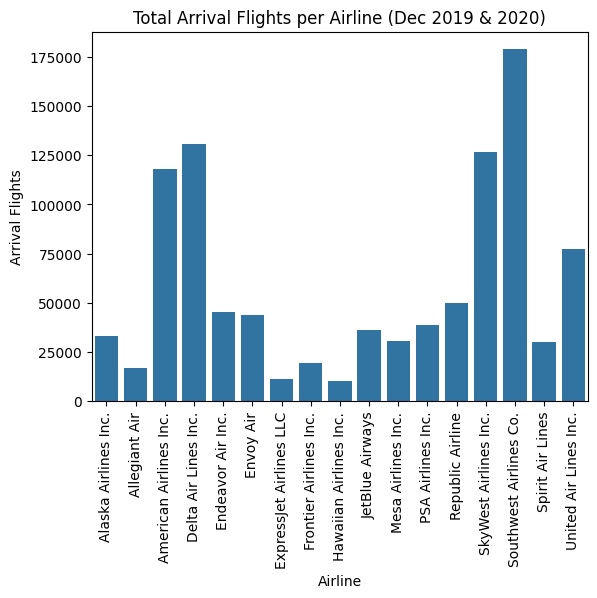

In [28]:
column_chart_arr_flights_code_writer = student_a

def visualize_airlines_arriving_flights(df: pd.DataFrame):
    arrival_by_airline = (
    df.groupby("carrier_name", as_index=False)["arr_flights"]
    .sum()
    .sort_values("carrier_name", ascending=True)
    )

    plt.figure()
    seaborn.barplot(
        data=arrival_by_airline,
        x="carrier_name",
        y="arr_flights"
    )

    plt.xlabel("Airline")
    plt.ylabel("Arrival Flights")
    plt.title("Total Arrival Flights per Airline (Dec 2019 & 2020)")
    plt.xticks(rotation=90)

    plt.show()


start_time_co = now()
visualize_airlines_arriving_flights(data)
end_time_co = now()

# 1. Activty: Checking for skewness and creating the report
co_ass_uuid_executor = "0181dba5-a4a3-4cd1-8813-829bad6ce1cb"
column_chart_executor = [
    f':column_chart_arr_flights prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(column_chart_executor, prefixes=prefixes)

co_ass_uuid_writer = "956f480d-faf2-41a3-9fa0-8d5b24aed821"
co_comment = """
The column chart visualizes the count of the arriving flights per airlines for December 2019 and 2020. On the x-Axis the Airlines are modeled and on the y-Axis the Arriving Flights.
"""
column_chart_arr_flights_activity = [
    ':column_chart_arr_flights rdf:type prov:Activity .',
    ':column_chart_arr_flights sc:isPartOf :data_understanding_phase .',
    ':column_chart_arr_flights rdfs:comment \'Data Understanding\' .',
    f':column_chart_arr_flights rdfs:comment """{co_comment}""" .',
    f':column_chart_arr_flights prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':column_chart_arr_flights prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':column_chart_arr_flights prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{column_chart_arr_flights_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':column_chart_arr_flights prov:used :data .',
    ':column_chart_arr_flights_report rdf:type prov:Entity .',
    f':column_chart_arr_flights_report rdfs:comment """Visualized the column chart.""" .',
    ':column_chart_arr_flights_report prov:wasGeneratedBy :column_chart_arr_flights .',
]
engine.insert(column_chart_arr_flights_activity, prefixes=prefixes)

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = "a6d6c34f-425d-4f76-871e-c234e51caeaa"
ior_comment = """
The column charts shows a large difference in arriving flights for the airlines. Southwest Airlines record the most amount of arriving flights wheres Hawaiian Airlines record the least."""
inspect_column_chart_arr_flights_executor = student_a
inspect_column_chart_arr_flights_activity = [
    ':inspect_column_chart_arr_flights rdf:type prov:Activity .',
    ':inspect_column_chart_arr_flights rdfs:comment \'Data Understanding\' .',
    f':inspect_column_chart_arr_flights rdfs:comment """{co_comment}""" .',
    f':inspect_column_chart_arr_flights prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_column_chart_arr_flights prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_column_chart_arr_flights prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_column_chart_arr_flights_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_column_chart_arr_flights prov:used :column_chart_arr_flights_report .',
]
engine.insert(inspect_column_chart_arr_flights_activity, prefixes=prefixes)

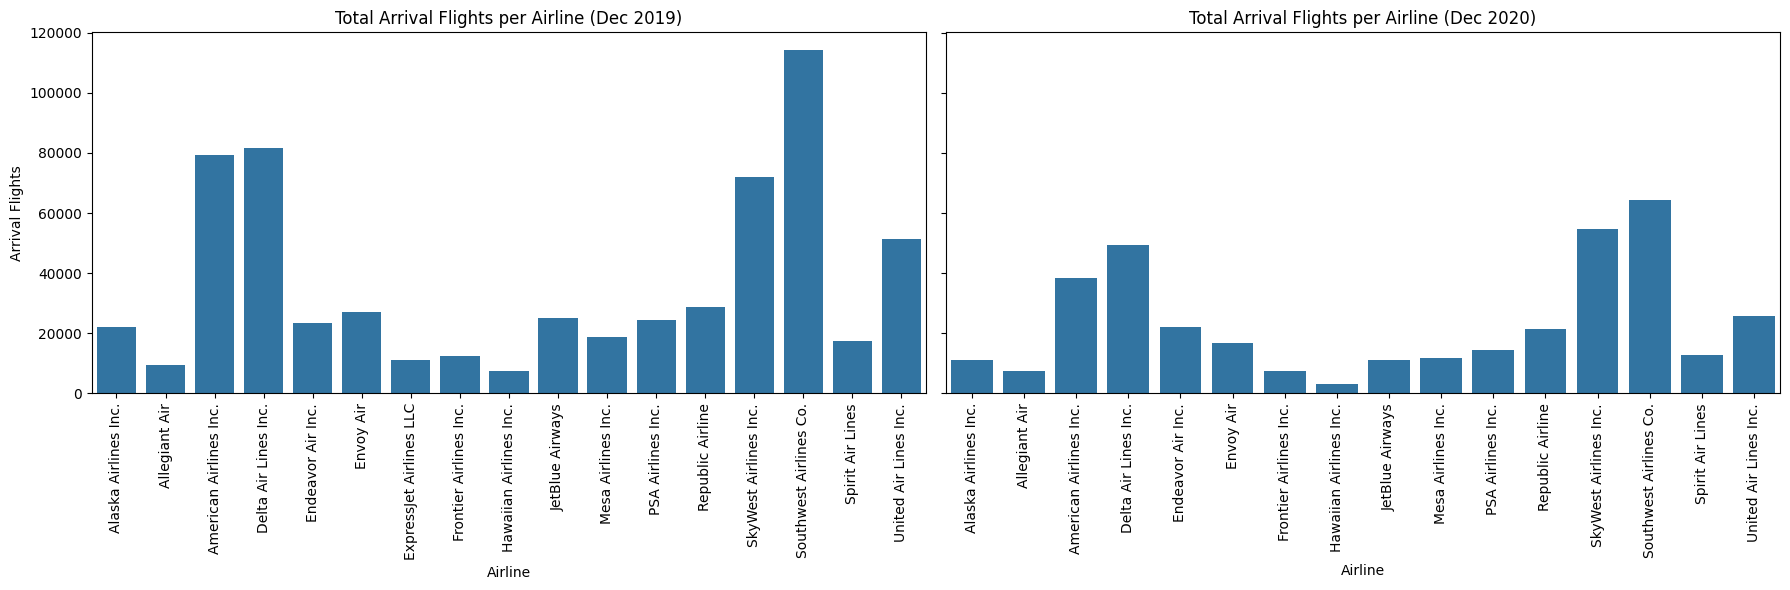

In [29]:
arr_flights_2019_2020_code_writer = student_a

def visualize_airlines_2019_2020_flights(df: pd.DataFrame):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    # 2019
    seaborn.barplot(
        data=df[df["year"] == 2019],
        x="carrier_name",
        y="arr_flights",
        ax=axes[0]
    )
    axes[0].set_title("Total Arrival Flights per Airline (Dec 2019)")
    axes[0].set_xlabel("Airline")
    axes[0].set_ylabel("Arrival Flights")
    axes[0].tick_params(axis="x", rotation=90)

    # 2020
    seaborn.barplot(
        data=df[df["year"] == 2020],
        x="carrier_name",
        y="arr_flights",
        ax=axes[1]
    )
    axes[1].set_title("Total Arrival Flights per Airline (Dec 2020)")
    axes[1].set_xlabel("Airline")
    axes[1].tick_params(axis="x", rotation=90)

    plt.tight_layout()
    plt.show()

start_time_co = now()
arrival_by_airline_year = (
    data
    .groupby(["year", "carrier_name"])
    .agg(arr_flights=("arr_flights", "sum"))
    .reset_index()
)
visualize_airlines_2019_2020_flights(arrival_by_airline_year)
end_time_co = now()

# 1. Activty: Checking for skewness and creating the report
co_ass_uuid_executor = "6056990a-f730-4d34-8283-0166740f96a4"
arr_flights_2019_2020_executor = [
    f':arr_flights_2019_2020 prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(arr_flights_2019_2020_executor, prefixes=prefixes)

co_ass_uuid_writer = "447317aa-91bd-4294-bb6f-f40aaedb295d"
co_comment = """
The column chart visualizes the count of the arriving flights per airlines for December 2019 and 2020 respectively. On the x-Axis the Airlines are modeled and on the y-Axis the Arriving Flights.
"""
arr_flights_2019_2020_activity = [
    ':arr_flights_2019_2020 rdf:type prov:Activity .',
    ':arr_flights_2019_2020 sc:isPartOf :data_understanding_phase .',
    ':arr_flights_2019_2020 rdfs:comment \'Data Understanding\' .',
    f':arr_flights_2019_2020 rdfs:comment """{co_comment}""" .',
    f':arr_flights_2019_2020 prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':arr_flights_2019_2020 prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':arr_flights_2019_2020 prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{arr_flights_2019_2020_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':arr_flights_2019_2020 prov:used :data .',
    ':arr_flights_2019_2020_report rdf:type prov:Entity .',
    f':arr_flights_2019_2020_report rdfs:comment """Column chart for 2019 and 2020 was visualized""" .',
    ':arr_flights_2019_2020_report prov:wasGeneratedBy :arr_flights_2019_2020 .',
]
engine.insert(arr_flights_2019_2020_activity, prefixes=prefixes)

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = "a6d6c34f-425d-4f76-871e-c234e51caeaa"
ior_comment = """
The column chart displays a noticeable difference between 2019 and 2020. Every airlines recorded fewer flights. This can be seen especially with big airlines like American Airlines, Delta Air Lines and Southwest Airlines. This could be traced back to the pandemic in 2020."""
inspect_arr_flights_2019_2020_executor = student_a
inspect_arr_flights_2019_2020_activity = [
    ':inspect_arr_flights_2019_2020 rdf:type prov:Activity .',
    ':inspect_arr_flights_2019_2020 rdfs:comment \'Data Understanding\' .',
    f':inspect_arr_flights_2019_2020 rdfs:comment """{co_comment}""" .',
    f':inspect_arr_flights_2019_2020 prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_arr_flights_2019_2020 prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_arr_flights_2019_2020 prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_arr_flights_2019_2020_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_arr_flights_2019_2020 prov:used :arr_flights_2019_2020_report .',
]
engine.insert(inspect_arr_flights_2019_2020_activity, prefixes=prefixes)

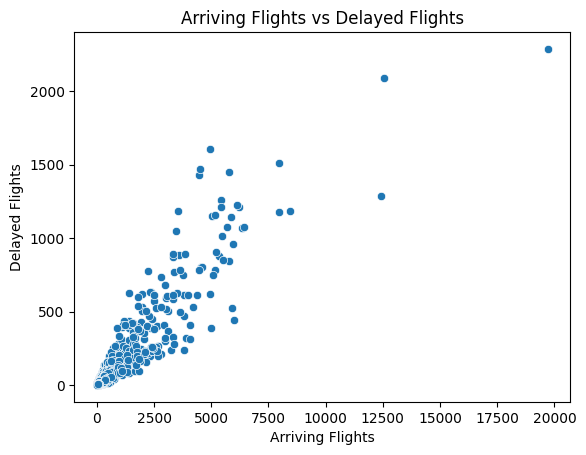

In [30]:
airlines_arriving_delayed_flights_code_writer = student_a

def visualize_airlines_arriving_delayed_flights(df: pd.DataFrame):
    plt.figure()
    seaborn.scatterplot(
        data=df,
        x="arr_flights",
        y="arr_del15"
    )

    plt.xlabel("Arriving Flights")
    plt.ylabel("Delayed Flights")
    plt.title("Arriving Flights vs Delayed Flights")

    plt.show()

start_time_co = now()
visualize_airlines_arriving_delayed_flights(data)
end_time_co = now()

# 1. Activty: Checking for skewness and creating the report
co_ass_uuid_executor = "b62381ea-68ea-40ed-a869-a9973e65b93d"
airlines_arriving_delayed_flights_executor = [
    f':airlines_arriving_delayed_flights prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(airlines_arriving_delayed_flights_executor, prefixes=prefixes)

co_ass_uuid_writer = "2b539dac-d302-4be1-8431-4d02dc41e213"
co_comment = """
The scatterplot visualized the correlation between arriving and delayed flights. On the x-Axis the arriving flights are modeled and on the y-Axis the delayed flights.
"""
airlines_arriving_delayed_flights_activity = [
    ':airlines_arriving_delayed_flights rdf:type prov:Activity .',
    ':airlines_arriving_delayed_flights sc:isPartOf :data_understanding_phase .',
    ':airlines_arriving_delayed_flights rdfs:comment \'Data Understanding\' .',
    f':airlines_arriving_delayed_flights rdfs:comment """{co_comment}""" .',
    f':airlines_arriving_delayed_flights prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':airlines_arriving_delayed_flights prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':airlines_arriving_delayed_flights prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{airlines_arriving_delayed_flights_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':airlines_arriving_delayed_flights prov:used :data .',
    ':airlines_arriving_delayed_flights_report rdf:type prov:Entity .',
    f':airlines_arriving_delayed_flights_report rdfs:comment """Scatterplot for arriving and delayed flights was visualized.""" .',
    ':airlines_arriving_delayed_flights_report prov:wasGeneratedBy :airlines_arriving_delayed_flights .',
]
engine.insert(airlines_arriving_delayed_flights_activity, prefixes=prefixes)

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = "a6d6c34f-425d-4f76-871e-c234e51caeaa"
ior_comment = """
The scatterplot shows a positive correlation between arriving and delayed flights. This could be interpreted as more arrivals correlate positive with more delayed flights."""
inspect_airlines_arriving_delayed_flights_executor = student_a
inspect_airlines_arriving_delayed_flights_activity = [
    ':inspect_airlines_arriving_delayed_flights rdf:type prov:Activity .',
    ':inspect_airlines_arriving_delayed_flights rdfs:comment \'Data Understanding\' .',
    f':inspect_airlines_arriving_delayed_flights rdfs:comment """{co_comment}""" .',
    f':inspect_airlines_arriving_delayed_flights prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_airlines_arriving_delayed_flights prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_airlines_arriving_delayed_flights prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_airlines_arriving_delayed_flights_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_airlines_arriving_delayed_flights prov:used :airlines_arriving_delayed_flights_report .',
]
engine.insert(inspect_airlines_arriving_delayed_flights_activity, prefixes=prefixes)

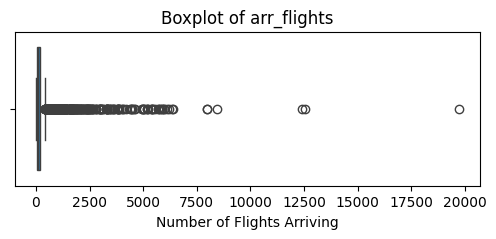

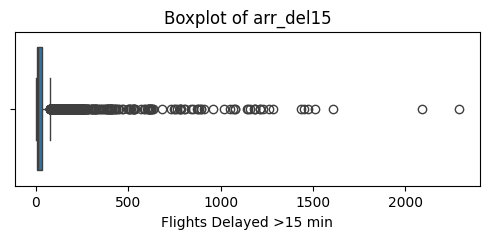

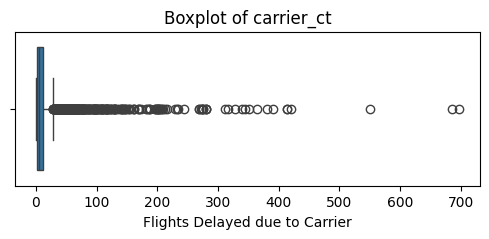

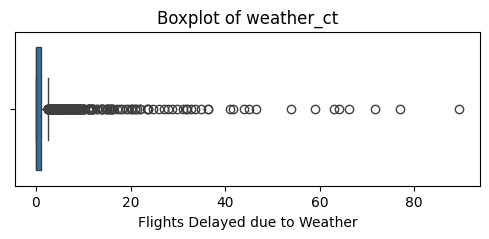

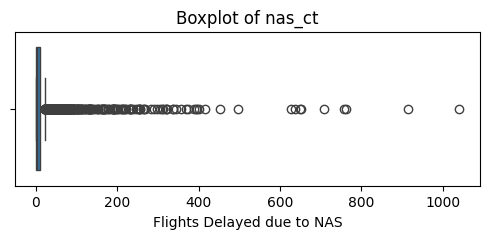

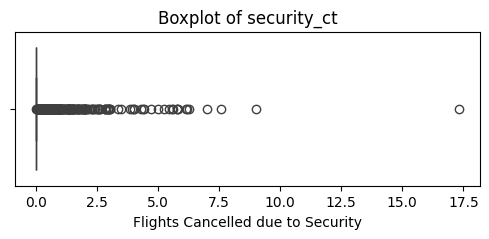

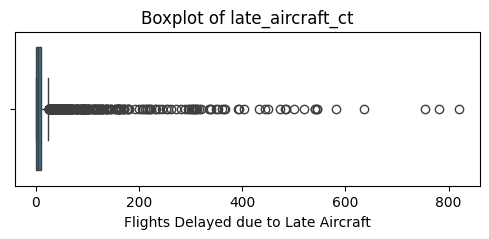

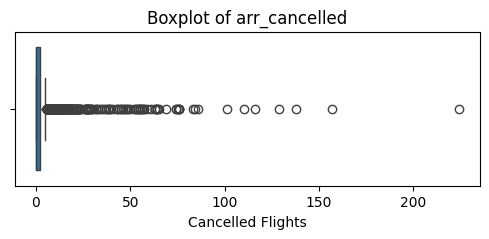

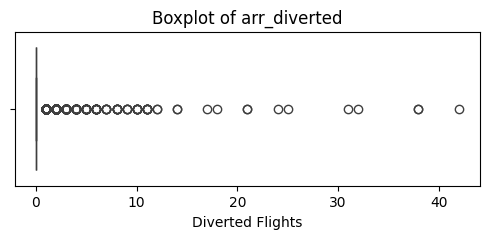

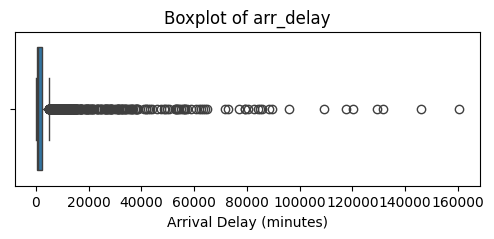

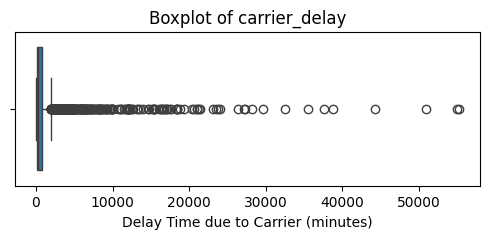

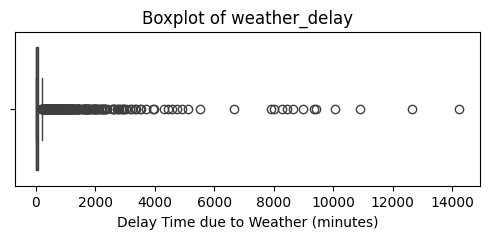

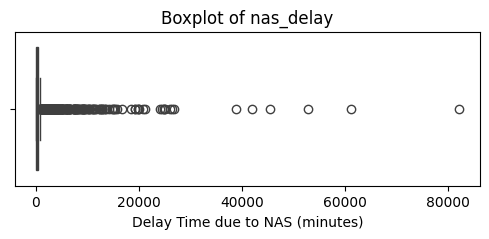

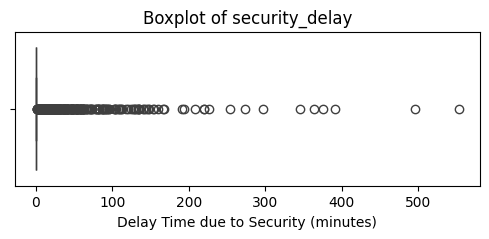

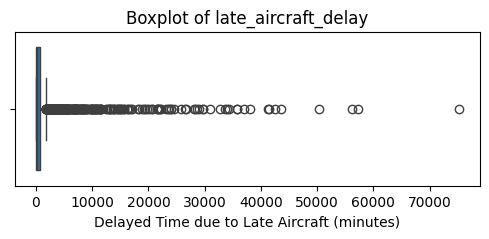

In [31]:
outliers_visualization_code_writer = student_a

def outliers_visualization(df: pd.DataFrame, columns: list):

    x_labels = {
    'arr_flights': 'Number of Flights Arriving',
    'arr_del15': 'Flights Delayed >15 min',
    'carrier_ct': 'Flights Delayed due to Carrier',
    'weather_ct': 'Flights Delayed due to Weather',
    'nas_ct': 'Flights Delayed due to NAS',
    'security_ct': 'Flights Cancelled due to Security',
    'late_aircraft_ct': 'Flights Delayed due to Late Aircraft',
    'late_aircraft_delay': 'Delayed Time due to Late Aircraft (minutes)',
    'arr_cancelled': 'Cancelled Flights',
    'arr_diverted': 'Diverted Flights',
    'arr_delay': 'Arrival Delay (minutes)',
    'carrier_delay': 'Delay Time due to Carrier (minutes)',
    'weather_delay': 'Delay Time due to Weather (minutes)',
    'nas_delay': 'Delay Time due to NAS (minutes)',
    'security_delay': 'Delay Time due to Security (minutes)',
    }

    for col in columns:
        plt.figure(figsize=(6,2))
        seaborn.boxplot(x=df[col])
        plt.title(f"Boxplot of {col}")
        plt.xlabel(x_labels.get(col, col))
        plt.show()

start_time_co = now()
outlier_report = outliers_visualization(data, numeric_cols)
end_time_co = now()

# 1. Activty: Checking for skewness and creating the report
co_ass_uuid_executor = "e7726ebf-a948-414c-af0c-5cbb34d8e83c"
outliers_visualization_executor = [
    f':outliers_visualization prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(outliers_visualization_executor, prefixes=prefixes)

co_ass_uuid_writer = "28cca8ce-55b2-410e-a490-e8fede217511"
co_comment = """
The dataset is visualized using boxplots for numeric columns to identify potential outliers. There have been indication about outliers in the kurtosis check before.
"""
outliers_visualization_activity = [
    ':outliers_visualization rdf:type prov:Activity .',
    ':outliers_visualization sc:isPartOf :data_understanding_phase .',
    ':outliers_visualization rdfs:comment \'Data Understanding\' .',
    f':outliers_visualization rdfs:comment """{co_comment}""" .',
    f':outliers_visualization prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':outliers_visualization prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':outliers_visualization prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{outliers_visualization_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':outliers_visualization prov:used :data .',
    ':outliers_visualization_report rdf:type prov:Entity .',
    f':outliers_visualization_report rdfs:comment """Boxplots generated to view outliers.""" .',
    ':outliers_visualization_report prov:wasGeneratedBy :outliers_visualization .',
]
engine.insert(outliers_visualization_activity, prefixes=prefixes)

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = "a6d6c34f-425d-4f76-871e-c234e51caeaa"
ior_comment = """
As indicated in the kurtosis check before number of delays due to security ans NAS show extreme outliers. Furthermore the columns of arriving and canceled flights show high outliers.
"""
inspect_outliers_visualization_executor = student_a
inspect_outliers_visualization_activity = [
    ':inspect_outliers_visualization rdf:type prov:Activity .',
    ':inspect_outliers_visualization rdfs:comment \'Data Understanding\' .',
    f':inspect_outliers_visualization rdfs:comment """{co_comment}""" .',
    f':inspect_outliers_visualization prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_outliers_visualization prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_outliers_visualization prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_outliers_visualization_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_outliers_visualization prov:used :outliers_visualization_report .',
    ':outliers_decision rdf:type prov:Entity .',
    f':outliers_decision rdfs:comment """Outliers will not be removed, as they have significant value to the airport and airline data." .""" .',
    ':outliers_decision prov:wasGeneratedBy :inspect_outliers_visualization .',
]
engine.insert(inspect_outliers_visualization_activity, prefixes=prefixes)

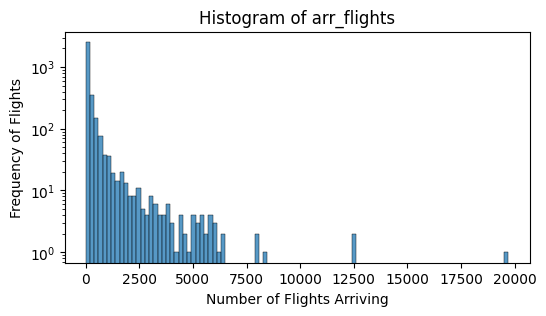

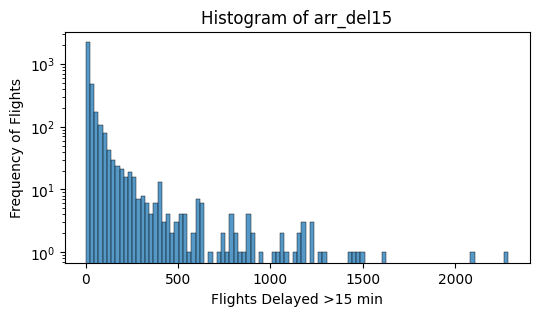

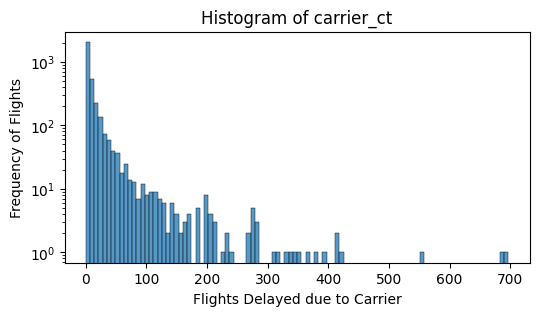

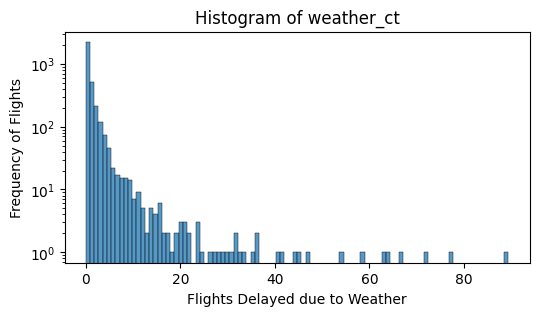

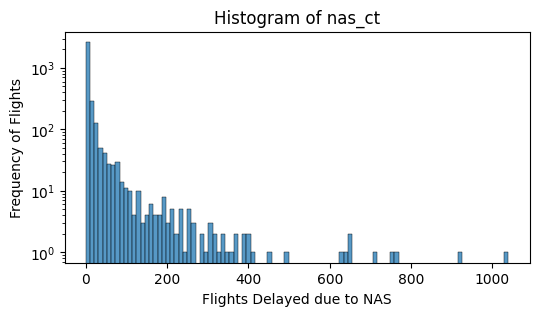

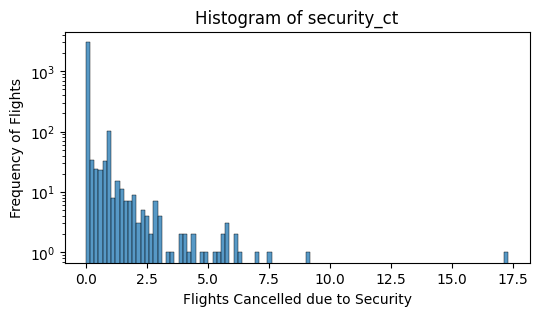

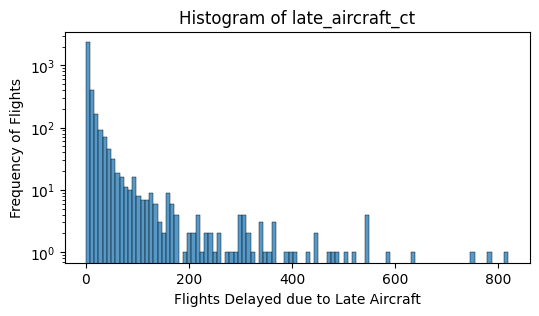

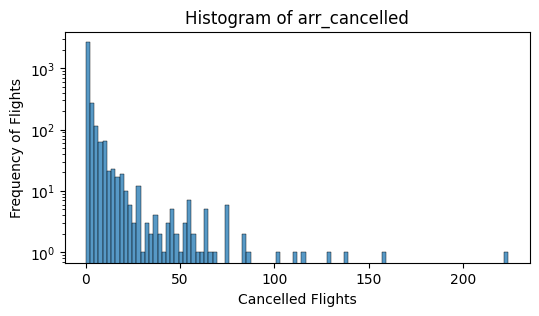

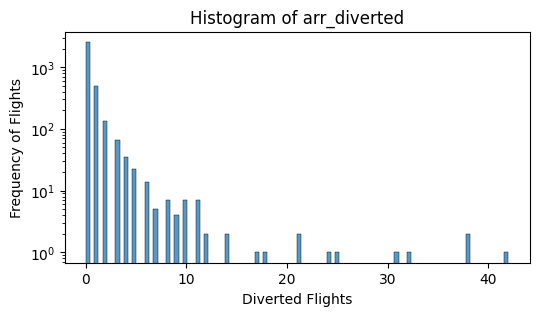

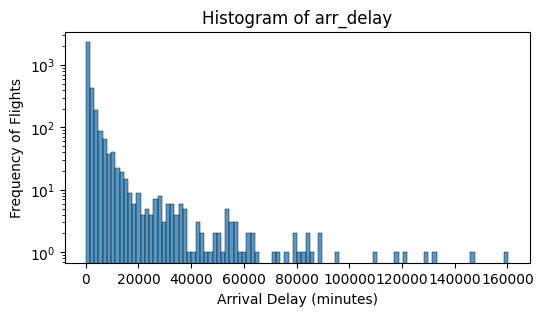

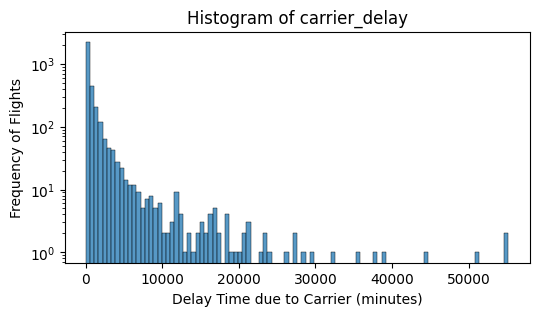

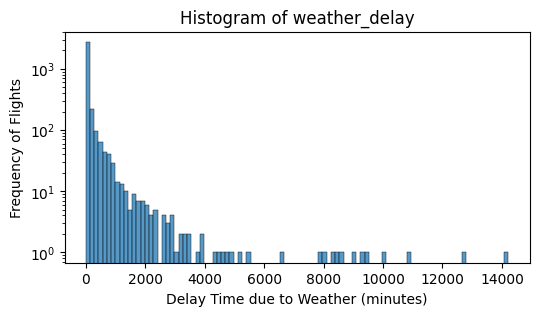

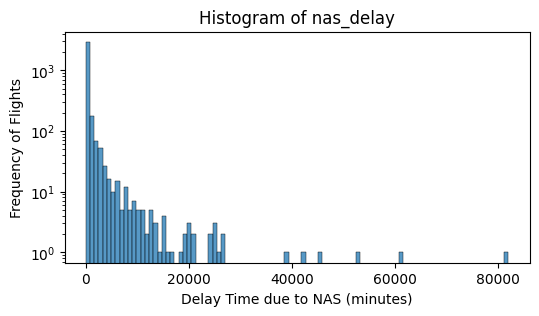

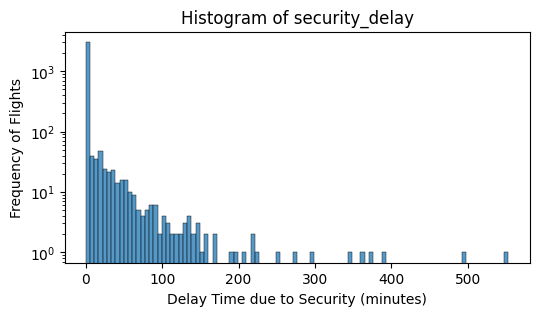

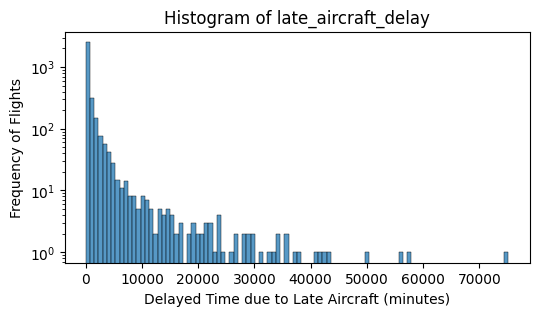

In [32]:
histogram_visualization_code_writer = student_a

def histogram(df: pd.DataFrame, columns: list):

    x_labels = {
    'arr_flights': 'Number of Flights Arriving',
    'arr_del15': 'Flights Delayed >15 min',
    'carrier_ct': 'Flights Delayed due to Carrier',
    'weather_ct': 'Flights Delayed due to Weather',
    'nas_ct': 'Flights Delayed due to NAS',
    'security_ct': 'Flights Cancelled due to Security',
    'late_aircraft_ct': 'Flights Delayed due to Late Aircraft',
    'late_aircraft_delay': 'Delayed Time due to Late Aircraft (minutes)',
    'arr_cancelled': 'Cancelled Flights',
    'arr_diverted': 'Diverted Flights',
    'arr_delay': 'Arrival Delay (minutes)',
    'carrier_delay': 'Delay Time due to Carrier (minutes)',
    'weather_delay': 'Delay Time due to Weather (minutes)',
    'nas_delay': 'Delay Time due to NAS (minutes)',
    'security_delay': 'Delay Time due to Security (minutes)',
    }

    for col in columns:
        plt.figure(figsize=(6,3))
        seaborn.histplot(df[col], bins=100, kde=False)
        plt.title(f"Histogram of {col}")
        plt.xlabel(x_labels.get(col, col))
        plt.ylabel("Frequency of Flights")
        plt.yscale('log')
        plt.show()

start_time_co = now()
histogram_chart = histogram(data, numeric_cols)
end_time_co = now()

# 1. Activty: Checking for skewness and creating the report
co_ass_uuid_executor = "a6b7e087-2ebe-4c76-ad2d-e0d49d6930dd"
histogram_executor = [
    f':histogram prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(histogram_executor, prefixes=prefixes)

co_ass_uuid_writer = "3631abe4-0d22-4f50-a3a1-57cc4ef29072"
co_comment = """
The dataset is visualized using histograms for numeric columns to display the distribution.
"""
check_outliers_activity = [
    ':histogram rdf:type prov:Activity .',
    ':histogram sc:isPartOf :data_understanding_phase .',
    ':histogram rdfs:comment \'Data Understanding\' .',
    f':histogram rdfs:comment """{co_comment}""" .',
    f':histogram prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':histogram prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':histogram prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{histogram_visualization_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':histogram prov:used :data .',
    ':histogram_report rdf:type prov:Entity .',
    f':histogram_report rdfs:comment """Histogram generated to show distribution .""" .',
    ':histogram_report prov:wasGeneratedBy :histogram .',
]
engine.insert(check_outliers_activity, prefixes=prefixes)

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = "a6d6c34f-425d-4f76-871e-c234e51caeaa"
ior_comment = """
The histograms show a right skewed distribution, with a concentration of low values. The outliers can be detected as well.
"""
inspect_histogram_executor = student_a
inspect_histogram_activity = [
    ':inspect_histogram rdf:type prov:Activity .',
    ':inspect_histogram rdfs:comment \'Data Understanding\' .',
    f':inspect_histogram rdfs:comment """{co_comment}""" .',
    f':inspect_histogram prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_histogram prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_histogram prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_histogram_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_histogram prov:used :histogram_report .',
    ':histogram_decision rdf:type prov:Entity .',
    f':histogram_decision rdfs:comment """Outliers will potentially removed in the preparation phase." .""" .',
    ':histogram_decision prov:wasGeneratedBy :inspect_histogram .',
]
engine.insert(inspect_histogram_activity, prefixes=prefixes)

In [33]:
ethically_sensitive_data_evaluation_code_writer = student_a

esde_uuid_writer = "0fd33448-69c3-4de3-8cb6-d9c5f785a646"

ethically_sensitive_data_evaluation = """
The dataset does not contain any personal or demographic data, making it low risk of ethical sensitivity. Smaller airlines such as Hawaiian Airlines Inc. show significantly lower amount of flights, than big airlines e.g. JetBlue Airways. Therefore the model will perform well for large airlines, but not for smaller airlines. Due to class imbalance between large and small airlines, macro-averaged evaluation metrics would be necessary to ensure equal performance. Oversampling of the smaller airlines could be used to reduce the bias caused by the imbalance.
"""

ethically_sensitive_data_evaluation_activity = [
    ':ethically_sensitive_data_evaluation rdf:type prov:Activity .',
    ':ethically_sensitive_data_evaluation sc:isPartOf :data_understanding_phase .',
    ':ethically_sensitive_data_evaluation rdfs:label "Data Understanding – Evaluation of ethically sensitive data" .',
    f':ethically_sensitive_data_evaluation rdfs:comment """{ethically_sensitive_data_evaluation}""" .',
    f':ethically_sensitive_data prov:qualifiedAssociation :{esde_uuid_writer} .',
    f':{esde_uuid_writer} prov:agent :{ethically_sensitive_data_evaluation_code_writer} .',
    f':{esde_uuid_writer} rdf:type prov:Association .',
    f':{esde_uuid_writer} prov:hadRole :{code_writer_role} .',
]

engine.insert(ethically_sensitive_data_evaluation_activity, prefixes=prefixes)

In [34]:
bias_evaluation_code_writer = student_a

be_uuid_writer = "55a4b8ea-7cc6-4f52-b8f5-80dfc0324e21"

bias_evaluation = """
As the dataset only covers the months of December, the other months are not represented. Therefore seasonal patterns can not be analyzed. As the dataset contains data of the year 2019 and 2020, comparisons might be skewed, because of the pandemic during December 2020. Large airlines with more frequent flights than smaller airlines dominate the dataset, leading to representation bias towards the bigger airlines. A risk could be missing data, or inconsistent reporting. An expert could give insights on how the pandemic influenced the number of flights, operational change and data quality, as most of the missing data values were recorded in the year 2020.
"""

bias_evaluation_activity = [
    ':bias_evaluation rdf:type prov:Activity .',
    ':bias_evaluation sc:isPartOf :data_understanding_phase .',
    ':bias_evaluation rdfs:label "Data Understanding – Risks and additional types of bias" .',
    f':bias_evaluation rdfs:comment """{bias_evaluation}""" .',
    f':bias_evaluation prov:qualifiedAssociation :{be_uuid_writer} .',
    f':{be_uuid_writer} prov:agent :{bias_evaluation_code_writer} .',
    f':{be_uuid_writer} rdf:type prov:Association .',
    f':{be_uuid_writer} prov:hadRole :{code_writer_role} .',
]

engine.insert(bias_evaluation_activity, prefixes=prefixes)

In [35]:
actions_code_writer = student_a

actions_uuid_writer = "b7d03e53-ac94-4237-aa74-03e03fe6b479"

actions_evaluation = """
The following actions are likely required based on the analysis.
Missing values should be removed to ensure the reliability of the results.
Scaling and potential log transformation may be necessary because of the skewness in the data.
Binning is likely required to better model differences in traffic volume and remove influence of outliers.
"""

actions_evaluation_activity = [
    ':actions_evaluation rdf:type prov:Activity .',
    ':actions_evaluation sc:isPartOf :data_understanding_phase .',
    ':actions_evaluation rdfs:label "Data Understanding – Potential actions to be taken" .',
    f':actions_evaluation rdfs:comment """{actions_evaluation}""" .',
    f':actions_evaluation prov:qualifiedAssociation :{actions_uuid_writer} .',
    f':{actions_uuid_writer} prov:agent :{actions_code_writer} .',
    f':{actions_uuid_writer} rdf:type prov:Association .',
    f':{actions_uuid_writer} prov:hadRole :{code_writer_role} .',
]

engine.insert(actions_evaluation_activity, prefixes=prefixes)

## Data Preparation

In [36]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
    f':data_preparation_phase rdf:type prov:Activity .',
    f':data_preparation_phase rdfs:label "Data Preparation Phase" .',
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [37]:
handle_outliers_code_writer = student_b


def handle_outliers(df: pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    df_clean = df.copy()
    n_start = len(df_clean)

    def log(rule_name, before, after):
        print(f"[{rule_name}] removed {before - after} rows (remaining: {after})")

    
    numeric_cols = [
    'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
    'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
    'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
    'security_delay', 'late_aircraft_delay'
    ]

    # Drop rows where we have NA values in some columns
    before = len(df_clean)
    df_clean = df_clean.dropna(subset=numeric_cols)
    after = len(df_clean)
    log("Drop NAs", before, after)
    
    # Drop rows with negative values where not meaningful
    before = len(df_clean)
    for col in numeric_cols:
        df_clean = df_clean[df_clean[col] >= 0]
    after = len(df_clean)
    log("Negative values", before, after)

    # Delayed flights cannot exceed arriving flights
    before = len(df_clean)
    df_clean = df_clean[df_clean["arr_del15"] <= df_clean["arr_flights"]]
    after = len(df_clean)
    log("Delayed > arriving flights", before, after)

    # Cancelled flights cannot exceed arriving flights
    before = len(df_clean)
    df_clean = df_clean[df_clean["arr_cancelled"] <= df_clean["arr_flights"]]
    after = len(df_clean)
    log("Cancelled > arriving flights", before, after)

    # Delay minutes must be zero if no delayed flights occurred
    before = len(df_clean)
    delay_min_cols = [
        "arr_delay", "carrier_delay", "weather_delay",
        "nas_delay", "security_delay", "late_aircraft_delay"
    ]
    no_delays = df_clean["arr_del15"] == 0
    for col in delay_min_cols:
        df_clean = df_clean[~(no_delays & (df_clean[col] > 0))]
    after = len(df_clean)
    log("Delay minutes with zero delayed flights", before, after)

    # Division-by-zero cases: arrivals == 0 but delays recorded
    before = len(df_clean)
    df_clean = df_clean[~((df_clean["arr_flights"] == 0) & (df_clean["arr_delay"] > 0))]
    after = len(df_clean)
    log("Arrivals = 0 with delay minutes", before, after)

    print(f"[TOTAL] removed {n_start - len(df_clean)} rows (final size: {len(df_clean)})")

    return df_clean

start_time_td = now()
cleaned_data = handle_outliers(data, data)
end_time_td = now()

#############################################
# Documentation
#############################################
# This is the continuation of the example from the Data Understanding phase above.
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => already done in data understanding phase
# 2. activity inspects the outcome and derives decisions => already done in data understanding phase
# 3. activity follows up on the decision by changing the data => in this case by removing the the outliers that were found

ro_ass_uuid_executor = "ec7e81e1-86ea-475a-a8d4-c7d8ee535488"
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "1405f15a-3545-4014-a962-637f3c10a137"
td_comment = """
Removing all outliers or unusual data points that cannot be used further in our model. We dropp rows with NAs, negative values (where it does not make sense) and remove also rows where we made a sanity check (e.g. delayed flights count cannot exceed total flights arrived).
"""
handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    #':handle_outliers rdfs:comment \'Data Preparation\' .',
    f':handle_outliers rdfs:comment """{td_comment}""" .',
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_outliers_activity, prefixes=prefixes)

[Drop NAs] removed 8 rows (remaining: 3343)
[Negative values] removed 0 rows (remaining: 3343)
[Delayed > arriving flights] removed 0 rows (remaining: 3343)
[Cancelled > arriving flights] removed 0 rows (remaining: 3343)
[Delay minutes with zero delayed flights] removed 0 rows (remaining: 3343)
[Arrivals = 0 with delay minutes] removed 0 rows (remaining: 3343)
[TOTAL] removed 8 rows (final size: 3343)


**Continue with other tasks of the Data Preparation phase such as binning, scaling etc...**

In [38]:
binning_delay_code_writer = student_b

start_time_bin = now()

cleaned_data["delay_severity"] = pd.qcut(
    cleaned_data["arr_delay"],
    q=[0, 0.25, 0.5, 0.75, 1.0],
    labels=["low", "medium", "high", "extreme"]
)

end_time_bin = now()

severity_counts = cleaned_data["delay_severity"].value_counts()
print(severity_counts)

#############################################
# Provenance logging

ro_ass_uuid_executor = "5c3b90e4-91a0-4b9f-9f12-61c9f6e6c321"
binning_delay_executor = [
    f':binning_delay_severity prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(binning_delay_executor, prefixes=prefixes)

td_ass_uuid_writer = "8a7e4f2c-9d7a-44bb-9a73-6c2c2d1aef91"
binning_comment = """
We created a derved attribute 'delay_severity' by applying quantile-based binning
to the arrival delay variable (arr_delay). The transformation maps the delays into
four severity levels (low, medium, high, extreme) with approximately equal-sized bins.
"""

binning_delay_activity = [
    ':binning_delay_severity rdf:type prov:Activity .',
    ':binning_delay_severity sc:isPartOf :data_preparation_phase .',
    f':binning_delay_severity rdfs:comment """{binning_comment}""" .',
    f':binning_delay_severity prov:startedAtTime "{start_time_bin}"^^xsd:dateTime .',
    f':binning_delay_severity prov:endedAtTime "{end_time_bin}"^^xsd:dateTime .',
    f':binning_delay_severity prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{binning_delay_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':binning_delay_severity prov:used :cleaned_data .',
    ':delay_severity rdf:type prov:Entity .',
    ':delay_severity prov:wasGeneratedBy :binning_delay_severity .',
    ':delay_severity prov:wasDerivedFrom :cleaned_data .',
]
engine.insert(binning_delay_activity, prefixes=prefixes)


delay_severity
low        837
extreme    836
medium     835
high       835
Name: count, dtype: int64


In [39]:
binning_traffic_code_writer = student_b

start_time_td = now()
cleaned_data["traffic_volume"] = (
    cleaned_data
    .groupby(["year", "month"])["arr_flights"]
    .transform(lambda x: pd.qcut(x, 3, labels=["low", "medium", "high"]))
)
end_time_td = now()

print(cleaned_data["traffic_volume"].value_counts())

ro_ass_uuid_executor = "f136a195-e581-46ba-a770-8172d8de9158"
binning_traffic_executor = [
    f':binning_traffic prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(binning_traffic_executor, prefixes=prefixes)

td_ass_uuid_writer = "32e2b69a-e958-4aca-b22f-88bf7c0f059a"
td_comment = """
We created bins for the traffic volume (variable traffic_volume) with the 3 categories "low", "medium", "high",
relative to other airport–carrier observations in the same year and month using monthly quantile-based bins.
"""

binning_traffic_activity = [
    ':binning_traffic rdf:type prov:Activity .',
    ':binning_traffic sc:isPartOf :data_preparation_phase .',
    f':binning_traffic rdfs:comment """{td_comment}""" .',
    f':binning_traffic prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':binning_traffic prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':binning_traffic prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{binning_traffic_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':binning_traffic prov:used :cleaned_data .',
    ':traffic_volume rdf:type prov:Entity .',
    ':traffic_volume prov:wasGeneratedBy :binning_traffic .',
    ':traffic_volume prov:wasDerivedFrom :cleaned_data .',
]
engine.insert(binning_traffic_activity, prefixes=prefixes)

traffic_volume
low       1126
high      1110
medium    1107
Name: count, dtype: int64


In [40]:
task3b_comment = """
Several preprocessing steps were considered but deliberately not applied:

- Outlier removal: The numerical variables are extreme right-skewed, so those values correspond to large airports, carriers or extreme delay events. If we would remove those, we would distort the business objective and underrepresent the major datapoints. We want to reserve the real world variability.

- Scaling/Log transformations: We decided to not scale some columns yet, since me may do that in the modeling phase if it is required by an algorithm

- Removal of attributes due to correlation: We have a strong correlation between arr_delay and carrier_delay, nas_delay, .. and also between  arr_del15 and other delay counts. We believe the different delay values encode different operational causes so we would remove some information which could be necessary for our business objective.

- Encoding of categorical attributes: We will do that in the modeling phase since it depends on which algorithm we use.

"""

task3b_activity = [
    ':task3b rdf:type prov:Activity .',
    ':task3b sc:isPartOf :data_preparation_phase .',
    ':task3b rdfs:label "Data Preparation – Considered but Not Applied Steps" .',
    f':task3b rdfs:comment """{task3b_comment}""" .'
]

engine.insert(task3b_activity, prefixes=prefixes)

In [41]:
task3c_comment = """
Several options for derived attributes were analyzed.

- Relative delay: arr_delay/arr_flights
with that we can easily compare delay across airports and carriers of different sizes, for small flight counts it could be unstable
- High potential

- Proportion of total delay attributable to each cause: e.g. weather_Delay/ arr_delay or carrier_delay / arr_delay
We can capture the structure of delays rather than absolute volume
- high potential

- Aggregation statistics: e.g. average delay per airport, cancellationrate per carrier
Capture historical performance, improve predictive performance (data leakage danger!)
- High potential
"""

task3c_activity = [
    ':task3c rdf:type prov:Activity .',
    ':task3c sc:isPartOf :data_preparation_phase .',
    ':task3c rdfs:label "Data Preparation – Derived Attribute Analysis" .',
    f':task3c rdfs:comment """{task3c_comment}""" .'
]

engine.insert(task3c_activity, prefixes=prefixes)


In [42]:
task3d_comment = """
Several external data sources were identified as potentially beneficial.

- Weather data: Observations linked to airport and date
- Airport infrastructure data: Characteristics like number of runways, passenger volume, runway utilization
- Airline operational characteristics: fleet size and age, network complexity
- Public holiday and event calendar: Flag major travel periods or high demand spikes caused by events
- Air traffic control: Information on airspace restrictions or other temporary regulations
"""

task3d_activity = [
    ':task3d rdf:type prov:Activity .',
    ':task3d sc:isPartOf :data_preparation_phase .',
    ':task3d rdfs:label "Data Preparation – External Data Source Analysis" .',
    f':task3d rdfs:comment """{task3d_comment}""" .'
]

engine.insert(task3d_activity, prefixes=prefixes)

In [43]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.

prepared_data_triples = [
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data rdf:type sc:Dataset .',
    ':prepared_data rdfs:label "Prepared Airline Delay Dataset" .',
    ':prepared_data prov:wasDerivedFrom :cleaned_data .',
    ':prepared_data prov:wasDerivedFrom :data .',
    ':prepared_data rdfs:comment """Final dataset after data preparation. Contains only valid, non-negative, and semantically consistent airline delay records. Used as input for the modeling phase.""" .'
]
engine.insert(prepared_data_triples, prefixes=prefixes)

## Modeling

In [ ]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
    f':modeling_phase rdf:type prov:Activity .',
    f':modeling rdfs:label "Modeling Phase" .',
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [ ]:
model_data_code_writer = student_a

#############################################
# Documentation 4a
#############################################

dma_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"
dma_comment = """
...
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # example algorithm definition
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Algorithm" .',

    # example implementation
    f':random_forrest_classifier_implementation rdf:type mls:Implementation .',
    f':random_forrest_classifier_implementation rdfs:label "Scikit-learn RandomForestClassifier" .',
    f':random_forrest_classifier_implementation mls:implements :random_forest_algorithm .',
    f':random_forrest_classifier_implementation prov:wasGeneratedBy :define_algorithm .',

    # you can also define your Evaluation Measures here

    # example evaluation 
    f':r2_score_measure rdf:type mls:EvaluationMeasure .',
    f':r2_score_measure rdfs:label "R-squared Score" .',
    f':r2_score_measure rdfs:comment "xxx" .',
    f':r2_score_measure prov:wasGeneratedBy :define_algorithm .',

]
engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [ ]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "fff582a8-c5cd-4030-978b-9f56b603167c"
hp_comment = """
...
"""
identify_hp_activity = [
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # example parameter
    f':hp_learning_rate rdf:type mls:HyperParameter .',
    f':hp_learning_rate rdfs:label "Learning Rate" .',
    f':hp_learning_rate rdfs:comment "..." .',
    f':random_forrest_classifier_implementation mls:hasHyperParameter :hp_learning_rate .',
    f':hp_learning_rate prov:wasGeneratedBy :identify_hyperparameters .',

    # continue with your identified hyperparameters

]
engine.insert(identify_hp_activity, prefixes=prefixes)

In [ ]:
def split_data(df: pd.DataFrame):
    #do something
    return 'train_set', 'validation_set', 'test_set'


#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "fb58ae6c-9d58-44c9-ac7e-529111bdf7fc"
split_comment = """
...
"""
## Use your prepared dataset
input_dataset = ":prepared_data"

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',

    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains xx samples" .',

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains xx samples" .',

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains xx samples" .',

]
engine.insert(define_split_activity, prefixes=prefixes)

In [ ]:
def train_and_finetune_model(training_set, validation_set):
    # do something here

    # Try to automate as much documentation work as possible.
    # Define your training runs with their respective hyperparameter settings, etc.
    # Document each time a training run, model, its hp_settings, evaluations, ...  
    # Create performance figures/graphs

    return 'Find most suitable model'


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now()

#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "21d60fe3-c9ab-4a0a-bae7-b9fe9653c755"
tafm_comment = """
...
"""

# EXAMPLE output from your training
training_run1 = "run_1"
model_run1 = "model_run1"
hp1_setting_run1 = "hp_setting_run1"
eval_train_run1 = "metric_train_run1"
eval_validation_run1 = "metric_validation_run1"

train_model_activity = [
    # Activity 
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    ########################################
    # ONE model run - automate everything below!

    # Parameter settings
    f':{hp1_setting_run1} rdf:type mls:HyperParameterSetting .',
    f':{hp1_setting_run1} mls:specifiedBy :hp_learning_rate .',
    f':{hp1_setting_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{hp1_setting_run1} prov:wasGeneratedBy :train_and_finetune_model .',
    # add your further parameters

    # Describe your Run
    f':{training_run1} rdf:type mls:Run .',
    f':{training_run1} sc:isPartOf :train_and_finetune_model .',
    f':{training_run1} mls:realizes :random_forest_algorithm .',
    f':{training_run1} rdf:label "Training Run 1 with..." .',
    f':{training_run1} mls:executes :your_implementation .',
    f':{training_run1} mls:hasInput :training_set .',
    f':{training_run1} mls:hasInput :validation_set .',
    f':{training_run1} mls:hasInput :{hp1_setting_run1} .',
    # list all your used parameters here
    f':{training_run1} mls:hasOutput :{model_run1} .',
    f':{training_run1} mls:hasOutput :{eval_train_run1} .',
    f':{training_run1} mls:hasOutput :{eval_validation_run1} .',

    # Describe your Model
    f':{model_run1} rdf:type mls:Model .',
    f':{model_run1} prov:label "xxx" .',
    f':{model_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{model_run1} mlso:trainedOn :training_set .',
    f':{model_run1} mlso:hasAlgorithmType :random_forest_algorithm .',

    # Describe your evaluations
    # You can have multiple evaluations per model 
    f':{eval_train_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_train_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_train_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_train_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_train_run1} prov:used :training_set .',

    f':{eval_validation_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_validation_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_validation_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_validation_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_validation_run1} prov:used :validation_set .',

    # Dont forget to document any visualizations

]
engine.insert(train_model_activity, prefixes=prefixes)


In [ ]:
def retrain_model_full_data(training_set, validation_set):
    # create your
    return "Final Trained Model"


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now()

#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "96815ee0-524c-437b-b5fa-2e15b945c993"  # Generate once

final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# Document the retraining activity.
# Hint: This activity is still part of the :modeling_phase

retrain_documentation = [
    # your documentation here    
]
engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation

In [ ]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
    f':evaluation_phase rdf:type prov:Activity .',
    f':evaluation_phase rdfs:label "Evaluation Phase" .',
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [ ]:
eval_code_writer = student_b


def evaluate_on_test_data(final_model, test_set):
    # Predict and evaluation on test data

    return 'Performance'


start_time_eval = now()
#evaluate_on_test_data()
end_time_eval = now()

#############################################
# Documentation
#############################################

eval_ass_uuid = "7f1431e9-feed-429a-92ed-c131b23cbe79"  # Generate once
final_model = ":final_model_entity"
test_set = ":test_set"

eval_comment = """
...
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',

    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',

    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance

    # Hint: you evaluate bias in this way:
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment "..." .',

]
engine.insert(evaluate_activity, prefixes=prefixes)

## Deployment

In [ ]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
    f':deployment_phase rdf:type prov:Activity .',
    f':deployment_phase rdfs:label "Deployment Phase" .',
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [ ]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "72a921e0-1234-4567-89ab-cdef01234567"  # Generate once
deployment_executor = [
    f':plan_deployment rdf:type prov:Activity .',
    f':plan_deployment sc:isPartOf :deployment_phase .',  # Connect to Parent Phase
    f':plan_deployment rdfs:label "Plan Deployment"@en .',

    f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
    f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{dep_ass_uuid_executor} rdf:type prov:Association .',
    f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(deployment_executor, prefixes=prefixes)

deployment_data_executor = [
    #6a
    f':dep_recommendations rdf:type prov:Entity .',
    f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
    f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
    f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
    #6b
    f':dep_ethical_risks rdf:type prov:Entity .',
    f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
    f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
    f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
    #6c
    f':dep_monitoring_plan rdf:type prov:Entity .',
    f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
    f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
    f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
    #6d
    f':dep_reproducibility_reflection rdf:type prov:Entity .',
    f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
    f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
    f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [44]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [45]:
# This cell includes cleaning functions

from datetime import datetime


def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"),
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"),
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text


def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')

    return s


def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [46]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty:  # type:ignore
    for _, row in res_authors.iterrows():  # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"

        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT ?ds_comment ?bo_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
}} LIMIT 1
"""
res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {}  # type:ignore
bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))

### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {}  # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Dataset Description
dd_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :dataset_description rdfs:comment ?desc . }} LIMIT 1
"""
res_dd_desc = engine.query(dd_desc_query)
row_dd_desc = res_dd_desc.iloc[0] if not res_dd_desc.empty else {}  # type:ignore
dd_description = latex_escape(clean_rdf(row_dd_desc.get("desc", "")))

dd_desc_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :description_report rdfs:comment ?comment .
}}
LIMIT 1
"""
res_dd = engine.query(dd_desc_query)
row_dd = res_dd.iloc[0] if not res_dd.empty else {}
dd_comment = latex_escape(clean_rdf(row_dd.get("comment", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query)
du_rows = []
if not res_du.empty:  # type:ignore
    for _, f in res_du.iterrows():  # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw:
            dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw:
            dtype = dtype_raw.split('/')[-1]
        else:
            dtype = dtype_raw

        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

### Data Preparation
dp_3outliers_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :handle_outliers rdfs:comment ?comment .
}}
LIMIT 1
"""
res_dp3outliers = engine.query(dp_3outliers_query)
row_dp3outliers = res_dp3outliers.iloc[0] if not res_dp3outliers.empty else {}
dp3outliers_comment = latex_escape(clean_rdf(row_dp3outliers.get("comment", "")))


### Task 3b
dp_3b_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :task3b rdfs:comment ?comment .
}}
LIMIT 1
"""
res_dp3b = engine.query(dp_3b_query)
row_dp3b = res_dp3b.iloc[0] if not res_dp3b.empty else {}
dp3b_comment = latex_escape(clean_rdf(row_dp3b.get("comment", "")))

dp_3c_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :task3c rdfs:comment ?comment .
}}
LIMIT 1
"""
res_dp3c = engine.query(dp_3c_query)
row_dp3c = res_dp3c.iloc[0] if not res_dp3c.empty else {}
dp3c_comment = latex_escape(clean_rdf(row_dp3c.get("comment", "")))

dp_3d_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :task3d rdfs:comment ?comment .
}}
LIMIT 1
"""
res_dp3d = engine.query(dp_3d_query)
row_dp3d = res_dp3d.iloc[0] if not res_dp3d.empty else {}
dp3d_comment = latex_escape(clean_rdf(row_dp3d.get("comment", "")))


dp_3summary_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :prepared_data rdfs:comment ?comment .
}}
LIMIT 1
"""
res_dp3summary = engine.query(dp_3summary_query)
row_dp3summary = res_dp3summary.iloc[0] if not res_dp3summary.empty else {}
dp3summary_comment = latex_escape(clean_rdf(row_dp3summary.get("comment", "")))

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty:  #type:ignore
    for _, row in res_hp.iterrows():  #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {}  #type:ignore
mod_algo = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

ZoneInfoNotFoundError: 'No time zone found with key Mitteleuropäische Zeit'

The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [ ]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {dd_comment}

The following features were identified in the dataset:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Handling outliers}}
{dp3outliers_comment}

\subsection{{Considered but Not Applied Pre-processing Steps}}
{dp3b_comment}
\subsection{{Analysis of Potential Derived Attributes}}
{dp3c_comment}
\subsection{{Analysis of Potential External Data Sources}}
{dp3d_comment}
\subsection{{Outcome of the Data Preparation Phase}}
{dp3summary_comment}


%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

%% --- 6. Deployment ---
\section{{Deployment}}

\section{{Conclusion}}

\end{{document}}
"""

In [ ]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")